# Remote Robot Edition
In this exercise we are going to go through the basics of remote controlling a liquid handler robot - OpenTrons OT-2

Useful Links:
- [API Documentation](https://docs.opentrons.com/v2/index.html)
- [Protocol Library](https://protocols.opentrons.com/)

Log: 
    - 20220112
    - 20220624
    - 20220714: need to optimize, due to the result of assembling not so good
    - 20220725: modify to use for another batch product
    - 20220816: to prufiy 13....45
    - 20220817: 46-61
    - 20220823: modify the original protocol into optimization of large size purification
    - 20220824: think of a way to dilute the sample in order to use more magnetic beads and elevated the output
    - 20220825: keep tuning the ratio
- use the api to do PCR, purification

In [1]:
# First, we load the OpenTrons library and call home
# Re-run this cell will reset the protocol!
from opentrons import protocol_api

metadata = {
    'protocolName': 'My Protocol',
    'author': 'Weiting <weitinglin66@gmail.com>',
    'description':'Simple protocol to get started using OT2',
    'apiLevl': '2.5'
}
        

In [2]:
import opentrons.execute
protocol = opentrons.execute.get_protocol_api('2.5')

Failed to initialize character device, will not be able to control gpios (lights, button, smoothiekill, smoothie reset). Only one connection can be made to the gpios at a time. If you need to control gpios, first stop the robot server with systemctl stop opentrons-robot-server. Until you restart the server with systemctl start opentrons-robot-server, you will be unable to control the robot using the Opentrons app.


# Load labware and pipete
Labware are the physical components mounted on the OpenTrons deck. Labware can include tips, wells, racks, etc.
We can see which labware is already part of the OpenTrons Labware Library.

p300:20 ul - 300 ul
p20: 1 - 20 uL

the labware we had:
## Reservour
1. NEST 96 Well Plate 100 uL: nest_96_wellplate_100ul_pcr_ful_skirt
2. Opentrons 24 Tube Rack with NEST 1.5 ml Snapcap: opentrons_24_tuberack_nest_1.5ml_snapcap
## Tips
3. Opentrons 96 Tips Rack 300 ul: opentrons_96_tiprack_300ul
4. Opentrons 96 Tips Rack 10 ul: opentrons_96_10ul


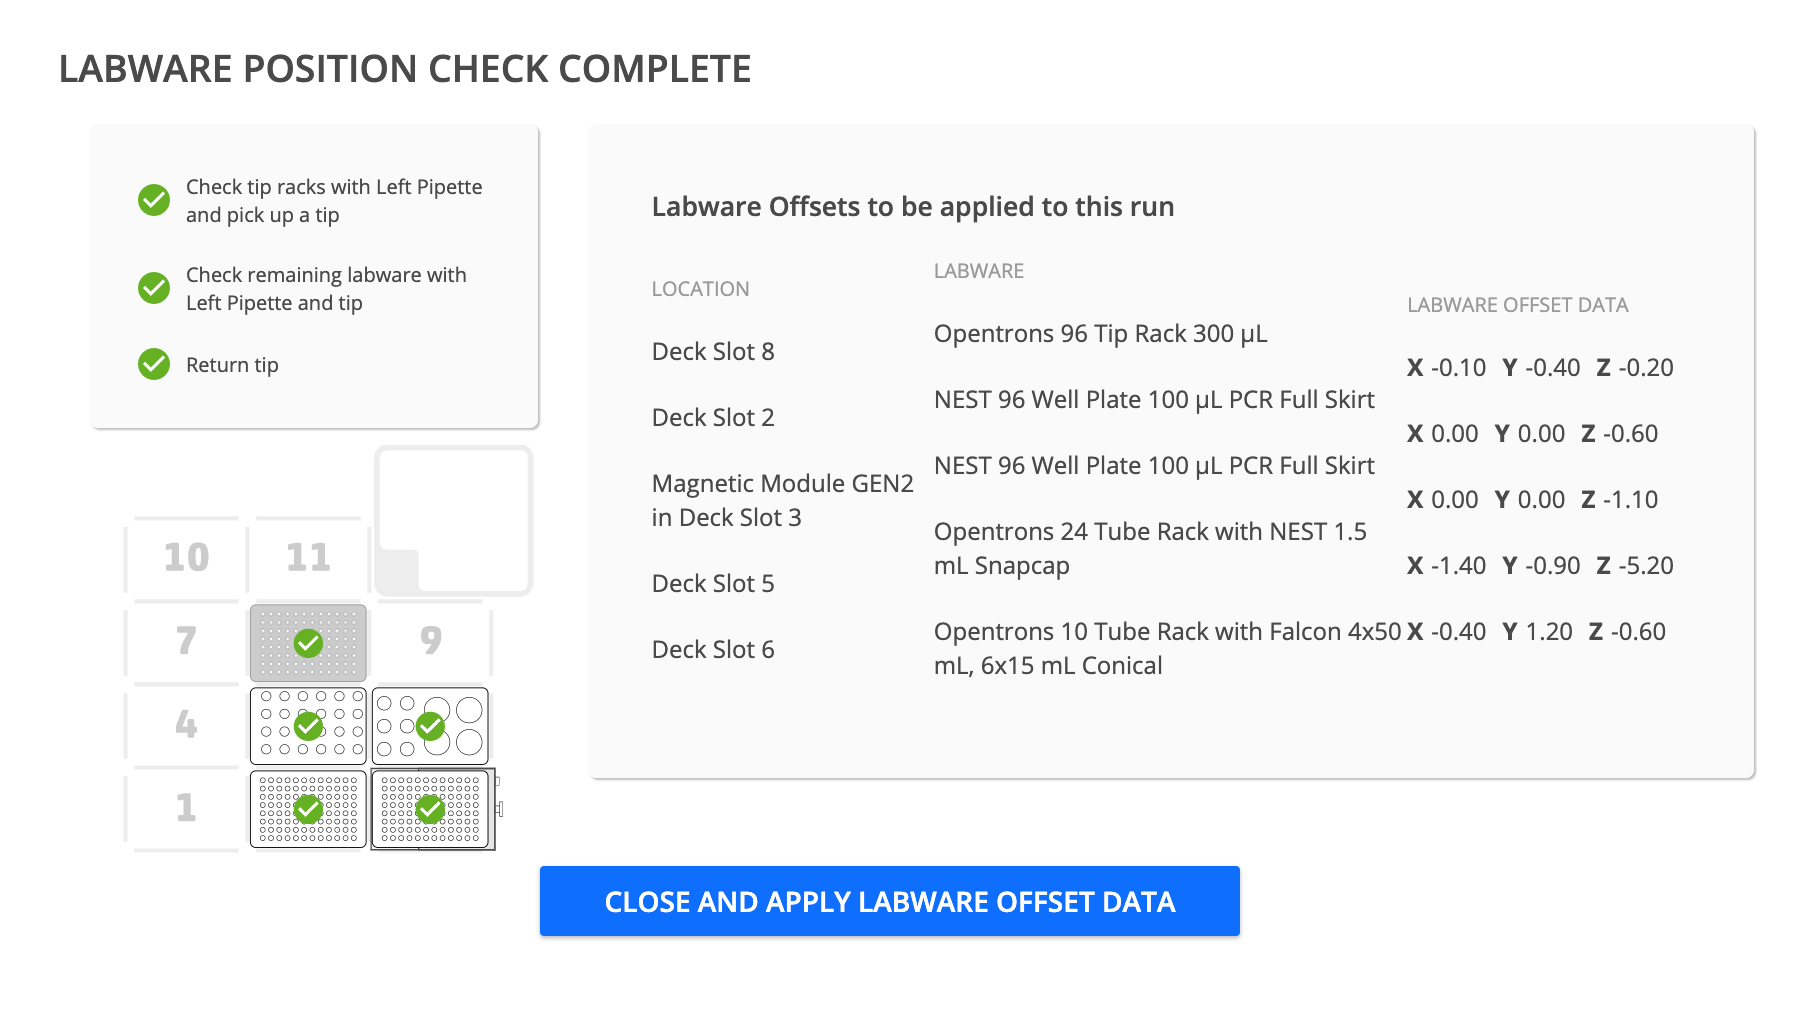
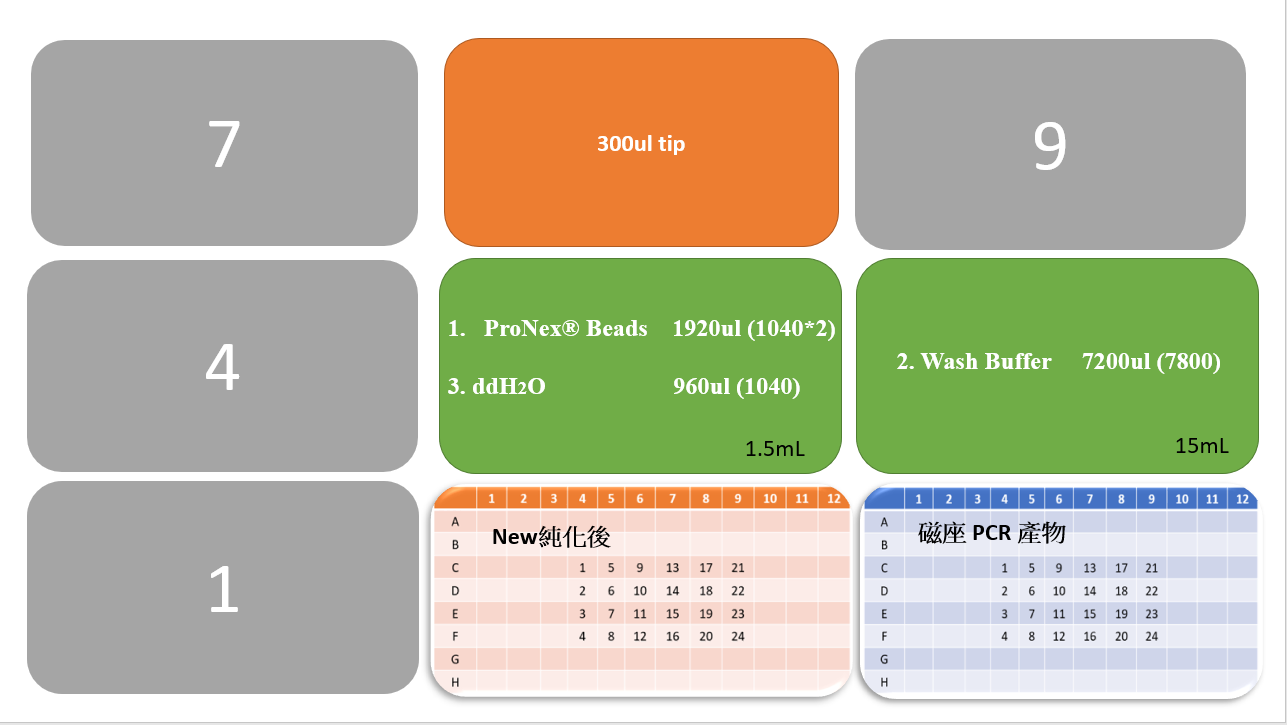



In [3]:
# Define the labware

# ==== Tips
tips_300 = protocol.load_labware('opentrons_96_tiprack_300ul',
                                 '8',
                                 'Opentrons Tips')
    


tips_20 = protocol.load_labware('opentrons_96_tiprack_20ul',
                                '7',
                                'Opentrons Tips')

# ==== Reservoir

LInput_container = protocol.load_labware('opentrons_24_tuberack_nest_1.5ml_snapcap',
                                     '5',
                                     'Product source')

Bigput_container = protocol.load_labware('opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical',
                                     '6',
                                     'Big Wash Buffer')


Output_container = protocol.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                         '2',
                                         'Purification Result')

#primers_screwcap = protocol.load_labware('opentrons_24_tuberack_nest_2ml_screwcap',
#                                             '5',
#                                             'Primer Source')

# ==== PCR mixture
#tc_mod = protocol.load_module('Thermocycler Module')
    
#PCR_plate = tc_mod.load_labware('nest_96_wellplate_100ul_pcr_full_skirt')

# ==== Magnetic Module

mag_mod = protocol.load_module('magnetic module gen2', '3')
    
    

Input_container = mag_mod.load_labware('nest_96_wellplate_100ul_pcr_full_skirt',
                                 label='Input reagent for magnetic extraction')


# ==== Pipette


left_pipette = protocol.load_instrument('p300_single',
                                              'left',
                                              tip_racks=[tips_300])

right_pipette = protocol.load_instrument('p20_single_gen2',
                                              'right',
                                              tip_racks=[tips_20])

In [17]:
al_tips_300 = protocol.load_labware('opentrons_96_tiprack_300ul',
                                 '11',
                                 'Opentrons Tips')

# Adjust the Position for Magnetic Purification 
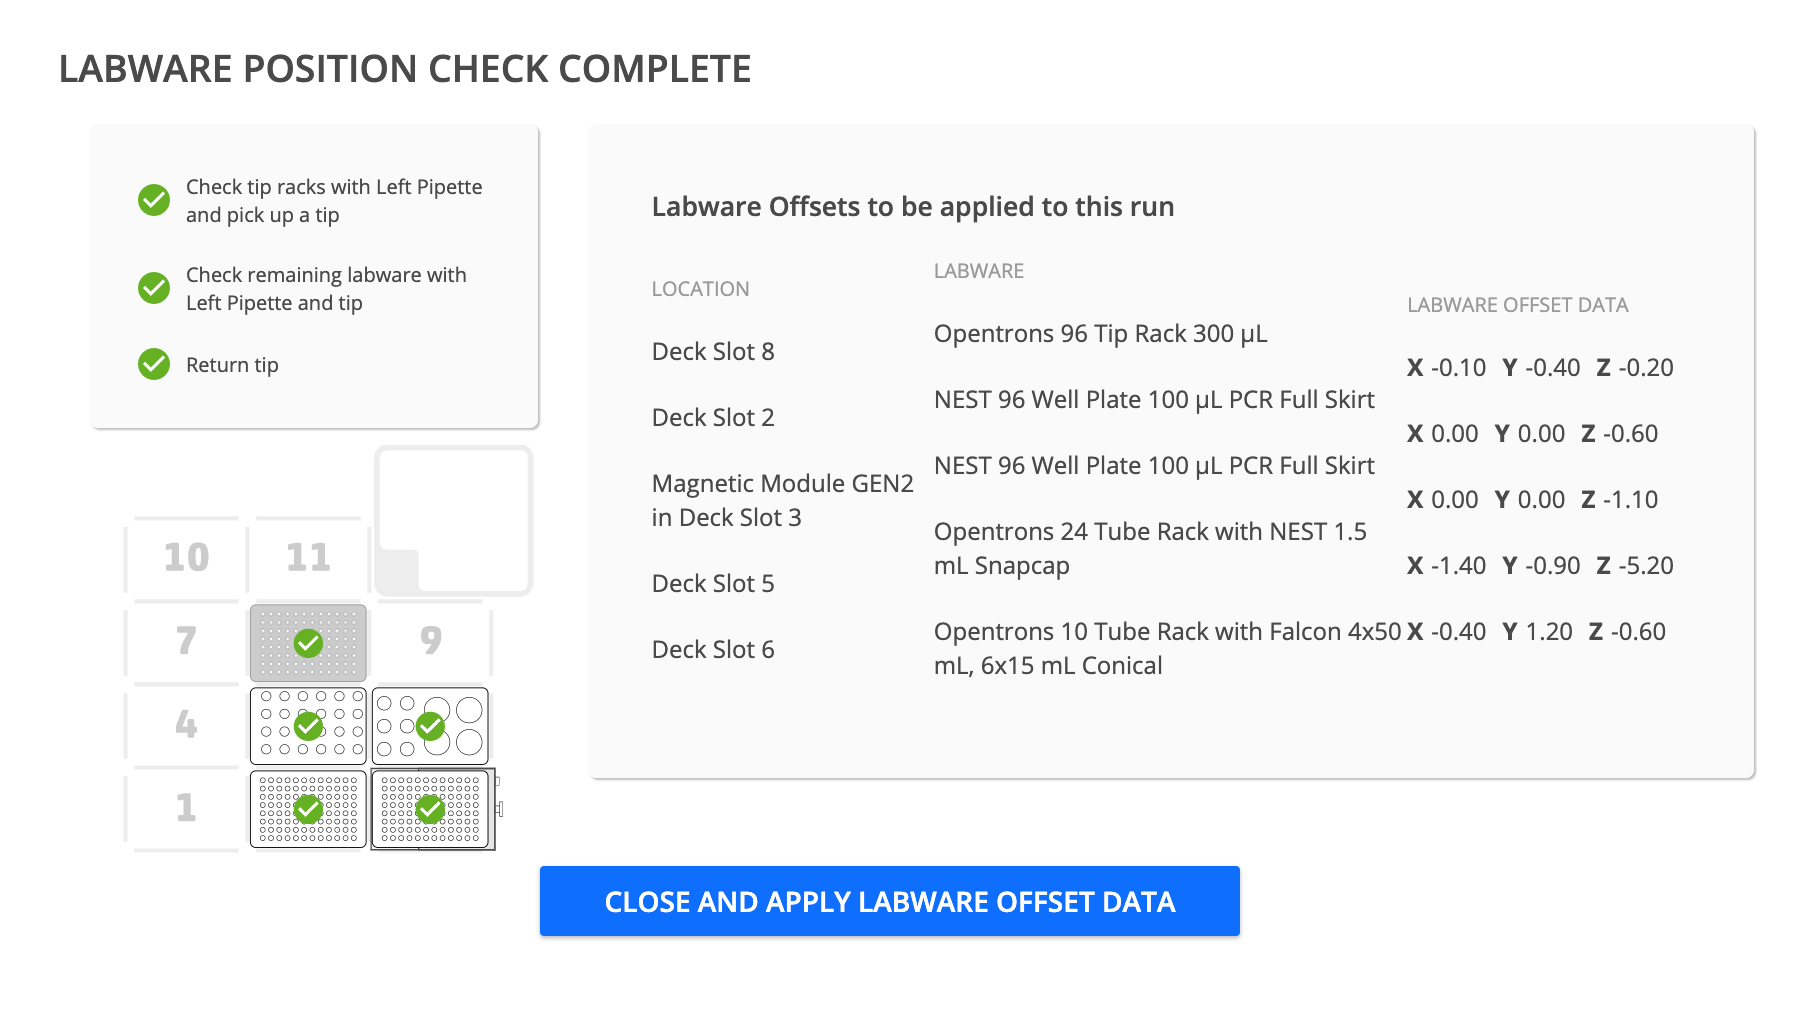

In [4]:
# Position Calibration with the data gathered from GUI workflow information
# Perfect!! we can use the GUI workflow for calibration, then take the parameter in the jupyter
# Tips

    
tips_300.set_offset(-0.1,-0.4,-0.2) # Slot 8

tips_20.set_offset(0,0,-0.5)  # Slot 7


# Reservoir
LInput_container.set_offset(-1.4, -0.9, -5.2)       # Slot 5

Bigput_container.set_offset(-0.4, 1.2, -0.6)       # Slot 6

Output_container.set_offset(0, 0, -0.6)    # Slot 2


    
# Magnetic Module
    
Input_container.set_offset(0, 0, -1.1)              
    
    

In [44]:
protocol.home()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0
Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


In [6]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
#https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key 20220822_38_Input_Layout.csv root@169.254.199.65:/root/script
# scp -i /Users/Weitinglin/Documents/Repository/opentron_202206/ot2_ssh_key 20220822_38_Output_Layout.csv root@169.254.199.65:/root/script

import csv
import string


input_24_combination_layout={}        
with open('/root/script/20220822_38_Input_Layout.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                input_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

output_24_combination_layout={}        
with open('/root/script/20220822_38_Output_Layout.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                output_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1
        

In [7]:
output_24_combination_layout

{'1': 'A1',
 '2': 'B1',
 '3': 'C1',
 '4': 'D1',
 '5': 'E1',
 '6': 'F1',
 '7': 'G1',
 '8': 'H1',
 '9': 'A2',
 '10': 'B2',
 '11': 'C2',
 '12': 'D2',
 '13': 'E2',
 '14': 'F2',
 '15': 'G2',
 '16': 'H2',
 '17': 'A3',
 '18': 'B3',
 '19': 'C3',
 '20': 'D3',
 '21': 'E3',
 '22': 'F3',
 '23': 'G3',
 '24': 'H3',
 '25': 'A4',
 '26': 'B4',
 '27': 'C4',
 '28': 'D4',
 '29': 'E4',
 '30': 'F4',
 '31': 'G4',
 '32': 'H4',
 '33': 'A5',
 '34': 'B5',
 '35': 'C5',
 '36': 'D5',
 '37': 'E5',
 '38': 'F5',
 '39': 'G5',
 '40': 'H5',
 '41': 'A6',
 '42': 'B6',
 '43': 'C6',
 '44': 'D6',
 '45': 'E6',
 '46': 'F6',
 '47': 'G6',
 '48': 'H6',
 '49': 'A7',
 '50': 'B7',
 '51': 'C7',
 '52': 'D7',
 '53': 'E7',
 '54': 'F7',
 '55': 'G7',
 '56': 'H7',
 '57': 'A8',
 '58': 'B8',
 '59': 'C8',
 '60': 'D8',
 '61': 'E8',
 '62': 'F8',
 '63': 'G8',
 '64': 'H8',
 '65': 'A9',
 '66': 'B9',
 '67': 'C9',
 '68': 'D9',
 '69': 'E9',
 '70': 'F9',
 '71': 'G9',
 '72': 'H9',
 '73': 'A10',
 '74': 'B10',
 '75': 'C10',
 '76': 'D10',
 '77': 'E10',
 '7

# Setup and Test Module SetOff
we use this section to define and tune the parameters, also define the function here before the execution


## function definition
### dispenseto24sample
- move 24 reagent according to its position
 - dispenseto24sampleChangetips
 - dispenseto24sampleOnetips
- mixing
 - fluidmix_mag


In [8]:
# ==========================================================================
# todo: the volume should calculate according to the condition
def dispenseto24sampleOnetips(volume, frompos, topos, layout):
    target_number = list(range(1,25))
    iter_target = iter(target_number)
    frompos = frompos
    topos = topos
    layout = layout
    iter_tips = tips
# tips change module =======================
    for time in list(range(1,5)):
        left_pipette.aspirate(240, frompos)
        for number in list(range(1, 7)):
            iter_number = next(iter_target)
            disperse_position = layout[f"{iter_number}"]
            left_pipette.dispense(volume, topos[disperse_position])
    left_pipette.drop_tip()
    return

# Example

# dispenseto24sample(tips=iter_tips,volume=40, frompos=LInput_container['D1'], topos=Input_container, layout=output_24_combination_layout)

# ==========================================================================
# todo: the volume should calculate according to the condition
def dispenseto24sampleChangetips(tips,volume, frompos, topos, layout):
    target_number = list(range(1,25))
    iter_target = iter(target_number)
    frompos = frompos
    topos = topos
    layout = layout
    iter_tips = tips
# tips change module =======================
    for time in list(range(1,5)):
        for number in list(range(1, 7)):
            left_pipett.pick_up_tip(tips_300[next(iter_tips)])
            left_pipette.aspirate(volume, frompos)
            iter_number = next(iter_tips)
            disperse_position = layout[f"{iter_number}"]
            left_pipette.dispense(volume, topos[disperse_position])
            left_pipette.drop_tip()

    return

# Example

# dispenseto24sampleChangetips(tips=iter_tips,volume=40, frompos=LInput_container['D1'], topos=Input_container, layout=output_24_combination_layout)

def countdownremind(sleeptime):
    for remaining in range(sleeptime, 0, -1):
        sys.stdout.write("\r")
        sys.stdout.write("{:2d} seconds remaining.".format(remaining))
        sys.stdout.flush()
        time.sleep(1)
    sys.stdout.write("\rComplete!                \n")


In [9]:
def fluidmix_mag(volume, time, position, bottom_a, bottom_d):
    total_time = time + 1

    for numb in list(range(1,total_time)):
        left_pipette.well_bottom_clearance.aspirate = bottom_a
        left_pipette.aspirate(volume, position)
        left_pipette.well_bottom_clearance.dispense = bottom_d
        left_pipette.dispense(volume, position)
        
    return

In [47]:
tip_num = []
for num in list(range(1,13)):
    for pos in list(range(1,9)):
        tmp_pos = f"{string.ascii_uppercase[pos-1]}{num}"
        tip_num.append(tmp_pos)


In [11]:
rt_iter_tips = iter(tip_num)

In [48]:
iter_tips = iter(tip_num)

In [42]:
len(tip_num[48:79])

31

## Refill the Tips ##

In [43]:
suptips  = tip_num[0:31]
intips = tip_num[48:79]

for number in list(range(0,31)):
    from_loc = suptips[number]
    to_loc = intips[number]
    left_pipette.pick_up_tip(al_tips_300[from_loc])
    left_pipette.drop_tip(tips_300[to_loc],home_after=False)
protocol.home()

In [79]:
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

# Preparation Steps
### Put DNA or Sample into the plate

In [15]:
iter_number = 1

In [45]:
left_pipette.pick_up_tip(tips_300[next(iter_tips)])

left_pipette.well_bottom_clearance.aspirate = 2 # 這高度就算可以惹
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹

for number in list(range(1,5)):
    left_pipette.aspirate(240, LInput_container['B1'])
    for time in list(range(1,7)):
        disperse_position = output_24_combination_layout[f"{next(iter_number)}"]
        left_pipette.dispense(40, Input_container[disperse_position])
    
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

# Preparation Steps
### Pre-Mixing the Magnetic Reagents

In [21]:
# ===================== Mixing the Magnetic Reagents ==================
left_pipette.well_bottom_clearance.dispense = 3  # 這高度就算可以惹
left_pipette.well_bottom_clearance.aspirate = 3
left_pipette.flow_rate.aspirate = 110
left_pipette.flow_rate.dispense = 130

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=5)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)

left_pipette.well_bottom_clearance.blow_out = 20
left_pipette.blow_out()
left_pipette.air_gap(volume=0.5)
left_pipette.drop_tip()
# ======================================================================

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


<InstrumentContext: p300_single_v2.1 in LEFT>

# Put Magnetic Reagents into the InputMag

In [35]:
# ===================== use 24 tips ================== 1
left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# 8:15 -> 8:45
target_number = list(range(1,25))
iter_target = iter(target_number)
# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
for time in list(range(1,3)):
    for number in list(range(1, 13)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        left_pipette.aspirate(80, LInput_container[f"{string.ascii_uppercase[time-1]}{1}"])
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        left_pipette.dispense(80, Input_container[disperse_position])
        left_pipette.flow_rate.aspirate = 30
        left_pipette.flow_rate.dispense = 45
        fluidmix_mag(volume=40, time=5, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
        left_pipette.well_bottom_clearance.blow_out = 1
        #left_pipette.blow_out()
        left_pipette.drop_tip()



In [12]:
list(range(25,33))

[25, 26, 27, 28, 29, 30, 31, 32]

# Add Volume to Sample

In [31]:
destination = input_24_combination_layout[f"{36}"]
    
right_pipette.pick_up_tip(tips_20[next(rt_iter_tips)])
right_pipette.well_bottom_clearance.dispense = 1
right_pipette.well_bottom_clearance.aspirate = 1
right_pipette.aspirate(18, LInput_container['C1'])
right_pipette.dispense(18, Input_container[destination])
right_pipette.blow_out()    
right_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


<InstrumentContext: p20_single_v2.1 in RIGHT>

In [30]:
list(range(33,41))

[33, 34, 35, 36, 37, 38, 39, 40]

In [34]:
# ===================== TO make the sample volume expans according to right ratio ==================
import time
import sys

print("=== Begine add ddH2O to expansion ===")
print("Start : %s" % time.ctime())

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
time_number = "33, 34, 35, 36, 37, 38, 39, 40" 
target_number = list(range(33,41))
#15+18
expan_volumes=[16, 18, 19, 15, 6, 8, 11, 14] # because 28 need 33, larger than 20, we seperate it from 18, 15
iter_expan_volumes=iter(expan_volumes)

for item in target_number:
    print("set item: ",item,"test")
    indiv_expan_volumes=next(iter_expan_volumes)
    destination = input_24_combination_layout[f"{item}"]
    
    right_pipette.pick_up_tip(tips_20[next(rt_iter_tips)])
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.aspirate(indiv_expan_volumes, LInput_container['C1'])
    right_pipette.dispense(indiv_expan_volumes, Input_container[destination])
    right_pipette.blow_out()    
    right_pipette.drop_tip()
    
    # 3 test: C7-> E4 weird
    # 4 test: C7-> E4 weird
print("End : %s" % time.ctime())

=== Begine add ddH2O to expansion ===
Start : Wed Aug 24 14:04:11 2022
set item:  33 test
set item:  34 test
set item:  35 test
set item:  36 test
set item:  37 test
set item:  38 test
set item:  39 test
set item:  40 test
End : Wed Aug 24 14:08:09 2022


In [46]:
# test magnetic module
mag_mod.engage(height=10)
mag_mod.disengage()

In [49]:
# ================================================================================
#
#               Prototpying and Tuning the magnetic purification
#     =        one at a time, with various ratio of mangetic beads      =
#
# ================================================================================
# log: 20220823
# set: 4 condition with repetition: 0.9 0.86 0.82 0.78 0.9 0.86 0.82 0.78
# set2: 9, 10, 11, 12, elongation eultion time from 30 -> 60 sec
# set3: 13, 14, 15, 16, 60 -> 90
# log 20220824
# set1:17 - 24
# log 20220825
# set: 25 - 32
# set: 33 - 40
import time
import sys
print("=== Begine the Magnetic Purification Protocol ===")
print("Start : %s" % time.ctime())

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# one time sample number


time_number = "33, 34, 35, 36, 37, 38, 39, 40" 
target_number = list(range(33,41))

# =============== Parameter Setting for the experiment =========
# =============== Location of test and output ==================

# position of magnetic reagent
location_of_magnetic = 'D1'

location_of_wash = 'A1'

location_of_waste = 'A2'

location_of_elution = 'C1'
# position of

# disperse_position = output_24_combination_layout[f"{time_number}"]

# volume of magnetic put into the sample
magneticreagnet_volume = 50
#magn_reagnet_vols = [45, 43, 41, 39, 45, 43, 41, 39]
#iter_magn_reagnet_vols = iter(magn_reagnet_vols)
# magnetic incubation time (seconds)
mag_incubation_time = 400  # 600 -> 900 -> 600 -> 900 -> 600 -> 900 -> 

mag_stir_time = 10 # 10->20->10

mag_stir_volume = 80 # 40 -> 80

mag_1st_height=10

# magnetic clear (seconds)
mag_clear_time = 150  # 120 -> 150
##===================================##
# aspiration Out the reagents
aspirate_out_volume = 98
aspirate_out_vols = [116, 119, 133, 106, 108, 108, 111, 114]
iter_aspirate_out_vols = iter(aspirate_out_vols)
# wash volume
wash_volume = 180  # 200 too high

# wash incubation time

wash_incubation_time = 60
##===================================##
# air drying time (seconds)

airdry_time = 2400

##===================================##
# elution mixture

elution_stir_time=14

elution_bottom_a=1

elution_bottom_d=2 # 1 -> 2

# elution volue
elution_volume = 50

# elution time 
elution_time = 900 # 300 -> 600 -> 300 -> 600 -> 900

# final aspirating elution volume
asp_elution_volume = 45 # 40 -> 45

print("=========== setting===============")
print(f"number of test: {time_number}")
print(f"incubation_time: {mag_incubation_time}")
print(f"mag_1st_height: {mag_1st_height}")
print(f"mag_clear_time: {mag_clear_time}")
print(f"magnetic volue:{magneticreagnet_volume}")
print(f"aspiration volue:{aspirate_out_vols}")
print(f"mag_incubation_time: {mag_incubation_time}")
print(f"asp_elution_volume: {asp_elution_volume}")
print(f"elution_time: {elution_time}")
print(f"mag_stir_time: {mag_stir_time}")
print("=========== setting===============")

# wash dispense height
wash_dispense_height = 7 # 5-> 7

# wash aspiration bottom heigh
wash_aspiration_bottom_height = 10

# ===================== Mixing the Magnetic Reagents ==================
left_pipette.well_bottom_clearance.dispense = 3  # 這高度就算可以惹
left_pipette.well_bottom_clearance.aspirate = 3
left_pipette.flow_rate.aspirate = 110
left_pipette.flow_rate.dispense = 130

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=5)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)

left_pipette.well_bottom_clearance.blow_out = 20
left_pipette.blow_out()
left_pipette.air_gap(volume=0.5)
left_pipette.drop_tip()

# ===============================================================

# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
print("=== Aspirating the magnetic mixture to the sample ===")



print("=== Mixing the reagent ===")
print("Start : %s" % time.ctime())

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item mixing".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]
    
    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
    
    #magnet_volume_test=next(iter_magn_reagnet_vols)
    
    left_pipette.aspirate(magneticreagnet_volume, LInput_container[location_of_magnetic])
    #left_pipette.aspirate(magnet_volume_test, LInput_container[location_of_magnetic])
    left_pipette.air_gap(volume=5)

    left_pipette.dispense(magneticreagnet_volume, Input_container[disperse_position])
    #left_pipette.dispense(magnet_volume_test, Input_container[disperse_position])

    left_pipette.flow_rate.aspirate = 30
    left_pipette.flow_rate.dispense = 45

    

    fluidmix_mag(volume=mag_stir_volume, time=mag_stir_time, position=Input_container[disperse_position], bottom_a=1, bottom_d=5)

    left_pipette.well_bottom_clearance.blow_out = 1
    left_pipette.blow_out()
    left_pipette.drop_tip()
    
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())

# =======================================
# Magnetic Purification
# =======================================


print("=== Begine the incubation ===")
print("Start : %s" % time.ctime())

#time.sleep(mag_incubation_time)
countdownremind(mag_incubation_time)

print("End : %s" % time.ctime())
# =======================================
# Magnetic Purification
# =======================================

print("=== Begin to suck Magnetic ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=mag_1st_height) # 10
countdownremind(mag_clear_time)

print("End : %s" % time.ctime())

# =======================================
# Discarding the supernatant
# =======================================

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# tips change module
print("=== Begin to discard supernatant ===")
print("Start : %s" % time.ctime())
for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item discard".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]
    
    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
    
    asp_out_volume=next(iter_aspirate_out_vols)

    #left_pipette.aspirate(aspirate_out_volume, Input_container[disperse_position])
    left_pipette.aspirate(asp_out_volume, Input_container[disperse_position])

    
    left_pipette.well_bottom_clearance.dispense = 80
    
    left_pipette.dispense(asp_out_volume, Bigput_container[location_of_waste])
    #left_pipette.dispense(aspirate_out_volume, Bigput_container[location_of_waste])
    
    left_pipette.blow_out()
    left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())

# =======================================
#              Wash 1st
# =======================================

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# Wait several minutes them wash

print("=== Wash 1st ===")
print("Start : %s" % time.ctime())
# tips change module
# blow_out split little bit out
for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("1st wash {:2d} item add".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
    left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height  # becare for this may damage the tip
    left_pipette.flow_rate.aspirate = 30 
    left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
    left_pipette.air_gap(volume=10)
    left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1 -> 5
    left_pipette.dispense(wash_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=10)
    left_pipette.drop_tip()
    
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())
    
print("Incubating the wash solution")
print("Start : %s" % time.ctime())
# time.sleep(wash_incubation_time)
countdownremind(wash_incubation_time)
print("End : %s" % time.ctime())
print("Remove the Wash Buffer")

# ===================== 1 tips usage =================== 
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("1st wash {:2d} item aspirate".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]

# pick tips
    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
               
    left_pipette.well_bottom_clearance.aspirate = 1 #  這高度就算可以惹
    left_pipette.aspirate(wash_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=10)
    left_pipette.well_bottom_clearance.dispense = 80
    left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
    left_pipette.drop_tip()

sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())

# =======================================
#              Wash 2nd
# =======================================
print("=== Wash 2nd time===")
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 4 tips usage ===================

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("2nd wash {:2d} item add".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
    left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height 
    left_pipette.flow_rate.aspirate = 30 
    left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
    left_pipette.air_gap(volume=10)
    left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1->5
    left_pipette.dispense(wash_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=10)
    #left_pipette.blow_out()
    left_pipette.drop_tip()
    
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())

print("Incubating the wash solution")
print("Start : %s" % time.ctime())

# time.sleep(wash_incubation_time)        # according to the sample's size
countdownremind(wash_incubation_time)

print("End : %s" % time.ctime())        
print("=== Romove the wash ===")
print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("2n wash {:2d} aspirate ".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
    left_pipette.well_bottom_clearance.aspirate = 1 # 1 這高度就算可以惹 turn 4 into 1, maybe a critical step
    left_pipette.aspirate(wash_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=10)
    left_pipette.well_bottom_clearance.dispense = 80
    left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
    left_pipette.drop_tip()

sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())


# =======================================
#             Airdrying the result
# =======================================
mag_mod.engage(height=9)
time.sleep(2)
# Wait several minutes for airdrying
print("=== Begin Air Drying ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=6)
time.sleep(2)
mag_mod.engage(height=4)
time.sleep(2)
mag_mod.engage(height=3)
time.sleep(2)
mag_mod.engage(height=1)
# time.sleep(airdry_time-4)
countdownremind(airdry_time-8)
print("End : %s" % time.ctime())

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53
for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item add elut".format(item))
    sys.stdout.flush()

    disperse_position = input_24_combination_layout[f"{item}"]
    
    left_pipette.flow_rate.aspirate = 20 
    left_pipette.flow_rate.dispense = 30

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
    left_pipette.well_bottom_clearance.aspirate = 1
    left_pipette.well_bottom_clearance.dispense = 1
        
    left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
    left_pipette.dispense(elution_volume, Input_container[disperse_position])
    left_pipette.flow_rate.aspirate = 70
    left_pipette.flow_rate.dispense = 110
    fluidmix_mag(volume=40, time=elution_stir_time, position=Input_container[disperse_position], bottom_a=elution_bottom_a, bottom_d=elution_bottom_d)
    left_pipette.air_gap(volume=10)
    left_pipette.drop_tip()

sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())
   

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item aspirat".format(item))
    sys.stdout.flush()
     
    output_position = output_24_combination_layout[f"{item}"]   
    disperse_position = input_24_combination_layout[f"{item}"]

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
    left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=2)
    left_pipette.dispense(asp_elution_volume, Output_container[output_position])
    left_pipette.blow_out()
    left_pipette.drop_tip()
    
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


=== Begine the Magnetic Purification Protocol ===
Start : Wed Aug 24 16:48:39 2022
=========== setting===============
number of test: 33, 34, 35, 36, 37, 38, 39, 40
incubation_time: 400
mag_clear_time: 150
magnetic volue:50
aspiration volue:[116, 119, 133, 106, 108, 108, 111, 114]
mag_incubation_time: 400
asp_elution_volume: 45
elution_time: 900
mag_stir_time: 10
=========== setting===============
=== Aspirating the magnetic mixture to the sample ===
=== Mixing the reagent ===
Start : Wed Aug 24 16:50:29 2022
Complete!                     
End : Wed Aug 24 17:01:33 2022
=== Begine the incubation ===
Start : Wed Aug 24 17:01:33 2022
Complete!                
End : Wed Aug 24 17:08:15 2022
=== Begin to suck Magnetic ===
Start : Wed Aug 24 17:08:15 2022
Complete!                
End : Wed Aug 24 17:10:47 2022
=== Begin to discard supernatant ===
Start : Wed Aug 24 17:10:47 2022
Complete!                     
End : Wed Aug 24 17:15:19 2022
=== Wash 1st ===
Start : Wed Aug 24 17:15:20 2022


In [34]:
# ===============================================
#
# Prototpying and Tuning the magnetic purification
#     =        one at a time: 12,13,14,15     =
# ===============================================
#
#
import time
import sys



print("=== Begine the Magnetic Purification Protocol ===")
print("Start : %s" % time.ctime())

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# =============== Parameter Setting for the experiment =========
# =============== Location of test and output ==================

# position of magnetic reagent
location_of_magnetic = 'D1'

location_of_wash = 'A1'

location_of_waste = 'A2'

location_of_elution = 'C1'
# position of

# disperse_position = output_24_combination_layout[f"{time_number}"]

# volume of magnetic put into the sample
magneticreagnet_volume = 40

# magnetic incubation time (seconds)
mag_incubation_time = 900  # 600 -> 900 -> 600 -> 900

# magnetic clear (seconds)
mag_clear_time = 120 

# aspiration Out the reagents
aspirate_out_volume = 88

# wash volume
wash_volume = 180  # 200 too high

# wash incubation time

wash_incubation_time = 60

# air drying time (seconds)

# airdry_time = 300

# elution volue
elution_volume = 50

# elution time 
elution_time = 300 # 300 -> 600 -> 300

# final aspirating elution volume
asp_elution_volume = 40


# wash dispense height
wash_dispense_height = 7 # 5-> 7

# wash aspiration bottom heigh
wash_aspiration_bottom_height = 10


time_number = 12
airdry_time = 2400
elution_time = 300
disperse_position = output_24_combination_layout[f"{time_number}"]

print("=========== setting===============")
print(f"number of test: {time_number}")
print(f"mag_incubation_time: {mag_incubation_time}")
print(f"elution_time: {elution_time}")
print("=========== setting===============")

# ===================== Mixing the Magnetic Reagents ==================
left_pipette.well_bottom_clearance.dispense = 3  # 這高度就算可以惹
left_pipette.well_bottom_clearance.aspirate = 3
left_pipette.flow_rate.aspirate = 110
left_pipette.flow_rate.dispense = 130

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=5)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)

left_pipette.well_bottom_clearance.blow_out = 20
left_pipette.blow_out()
left_pipette.air_gap(volume=0.5)
left_pipette.drop_tip()
# ======================================================================



# ===============================================================

# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
print("=== Aspirating the magnetic mixture to the sample ===")

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

left_pipette.aspirate(magneticreagnet_volume, LInput_container[location_of_magnetic])
left_pipette.air_gap(volume=5)

left_pipette.dispense(magneticreagnet_volume, Input_container[disperse_position])

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 45

print("=== Mixing the reagent ===")

fluidmix_mag(volume=40, time=10, position=Input_container[disperse_position], bottom_a=1, bottom_d=5)

left_pipette.well_bottom_clearance.blow_out = 1
left_pipette.blow_out()
left_pipette.drop_tip()

# =======================================
# Magnetic Purification
# =======================================


print("=== Begine the incubation ===")
print("Start : %s" % time.ctime())

#time.sleep(mag_incubation_time)
countdownremind(mag_incubation_time)

print("End : %s" % time.ctime())
# =======================================
# Magnetic Purification
# =======================================

print("=== Begin to suck Magnetic ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=10)
countdownremind(mag_clear_time)

print("End : %s" % time.ctime())

# =======================================
# Discarding the supernatant
# =======================================

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# tips change module
print("=== Begin to aspirate supernatant ===")
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       

left_pipette.aspirate(aspirate_out_volume, Input_container[disperse_position])
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(aspirate_out_volume, Bigput_container[location_of_waste])
left_pipette.blow_out()
left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

# =======================================
#              Wash 1st
# =======================================

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# Wait several minutes them wash
print("Start : %s" % time.ctime())
print("=== Wash 1st ===")

# tips change module
# blow_out split little bit out

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height  # becare for this may damage the tip
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1 -> 5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()
print("Incubating the wash solution")
print("Start : %s" % time.ctime())
# time.sleep(wash_incubation_time)
countdownremind(wash_incubation_time)
print("End : %s" % time.ctime())
print("Remove the Wash Buffer")

# ===================== 1 tips usage =================== 
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

# pick tips
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
               
left_pipette.well_bottom_clearance.aspirate = 1 #  這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()
print("End : %s" % time.ctime())

# =======================================
#              Wash 2nd
# =======================================
print("=== Wash 2nd time===")
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 1 tips usage ===================

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height 
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1->5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
#left_pipette.blow_out()
left_pipette.drop_tip()

print("Incubating the wash solution")
print("Start : %s" % time.ctime())

# time.sleep(wash_incubation_time)        # according to the sample's size
countdownremind(wash_incubation_time)

print("End : %s" % time.ctime())        
print("=== Romove the wash ===")
print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30


left_pipette.pick_up_tip(tips_300[next(iter_tips)])
left_pipette.well_bottom_clearance.aspirate = 1 # 1 這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()


# =======================================
#             Airdrying the result
# =======================================
mag_mod.engage(height=9)
time.sleep(2)
# Wait several minutes for airdrying
print("=== Begin Air Drying ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=6)
time.sleep(2)
mag_mod.engage(height=4)
time.sleep(2)
mag_mod.engage(height=3)
time.sleep(2)
mag_mod.engage(height=1)
# time.sleep(airdry_time-4)
countdownremind(airdry_time-8)
print("End : %s" % time.ctime())

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
left_pipette.well_bottom_clearance.aspirate = 1
left_pipette.well_bottom_clearance.dispense = 1
        
left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
left_pipette.dispense(elution_volume, Input_container[disperse_position])
left_pipette.flow_rate.aspirate = 70
left_pipette.flow_rate.dispense = 110
fluidmix_mag(volume=40, time=14, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=2)
left_pipette.dispense(asp_elution_volume, Output_container[disperse_position])
left_pipette.drop_tip()
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())




time_number = 13
airdry_time = 2400
elution_time = 600
disperse_position = output_24_combination_layout[f"{time_number}"]
print("=========== setting===============")
print(f"number of test: {time_number}")
print(f"mag_incubation_time: {mag_incubation_time}")
print(f"elution_time: {elution_time}")
print("=========== setting===============")

# ===================== Mixing the Magnetic Reagents ==================
left_pipette.well_bottom_clearance.dispense = 3  # 這高度就算可以惹
left_pipette.well_bottom_clearance.aspirate = 3
left_pipette.flow_rate.aspirate = 110
left_pipette.flow_rate.dispense = 130

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=5)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)

left_pipette.well_bottom_clearance.blow_out = 20
left_pipette.blow_out()
left_pipette.air_gap(volume=0.5)
left_pipette.drop_tip()
# ======================================================================



# ===============================================================

# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
print("=== Aspirating the magnetic mixture to the sample ===")

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

left_pipette.aspirate(magneticreagnet_volume, LInput_container[location_of_magnetic])
left_pipette.air_gap(volume=5)

left_pipette.dispense(magneticreagnet_volume, Input_container[disperse_position])

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 45

print("=== Mixing the reagent ===")

fluidmix_mag(volume=40, time=10, position=Input_container[disperse_position], bottom_a=1, bottom_d=5)

left_pipette.well_bottom_clearance.blow_out = 1
left_pipette.blow_out()
left_pipette.drop_tip()

# =======================================
# Magnetic Purification
# =======================================


print("=== Begine the incubation ===")
print("Start : %s" % time.ctime())

#time.sleep(mag_incubation_time)
countdownremind(mag_incubation_time)

print("End : %s" % time.ctime())
# =======================================
# Magnetic Purification
# =======================================

print("=== Begin to suck Magnetic ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=10)
countdownremind(mag_clear_time)

print("End : %s" % time.ctime())

# =======================================
# Discarding the supernatant
# =======================================

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# tips change module
print("=== Begin to aspirate supernatant ===")
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       

left_pipette.aspirate(aspirate_out_volume, Input_container[disperse_position])
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(aspirate_out_volume, Bigput_container[location_of_waste])
left_pipette.blow_out()
left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

# =======================================
#              Wash 1st
# =======================================

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# Wait several minutes them wash
print("Start : %s" % time.ctime())
print("=== Wash 1st ===")

# tips change module
# blow_out split little bit out

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height  # becare for this may damage the tip
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1 -> 5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()
print("Incubating the wash solution")
print("Start : %s" % time.ctime())
# time.sleep(wash_incubation_time)
countdownremind(wash_incubation_time)
print("End : %s" % time.ctime())
print("Remove the Wash Buffer")

# ===================== 1 tips usage =================== 
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

# pick tips
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
               
left_pipette.well_bottom_clearance.aspirate = 1 #  這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()
print("End : %s" % time.ctime())

# =======================================
#              Wash 2nd
# =======================================
print("=== Wash 2nd time===")
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 1 tips usage ===================

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height 
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1->5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
#left_pipette.blow_out()
left_pipette.drop_tip()

print("Incubating the wash solution")
print("Start : %s" % time.ctime())

# time.sleep(wash_incubation_time)        # according to the sample's size
countdownremind(wash_incubation_time)

print("End : %s" % time.ctime())        
print("=== Romove the wash ===")
print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30


left_pipette.pick_up_tip(tips_300[next(iter_tips)])
left_pipette.well_bottom_clearance.aspirate = 1 # 1 這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()


# =======================================
#             Airdrying the result
# =======================================
mag_mod.engage(height=9)
time.sleep(2)
# Wait several minutes for airdrying
print("=== Begin Air Drying ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=6)
time.sleep(2)
mag_mod.engage(height=4)
time.sleep(2)
mag_mod.engage(height=3)
time.sleep(2)
mag_mod.engage(height=1)
# time.sleep(airdry_time-4)
countdownremind(airdry_time-8)
print("End : %s" % time.ctime())

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
left_pipette.well_bottom_clearance.aspirate = 1
left_pipette.well_bottom_clearance.dispense = 1
        
left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
left_pipette.dispense(elution_volume, Input_container[disperse_position])
left_pipette.flow_rate.aspirate = 70
left_pipette.flow_rate.dispense = 110
fluidmix_mag(volume=40, time=14, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=2)
left_pipette.dispense(asp_elution_volume, Output_container[disperse_position])
left_pipette.drop_tip()
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())



time_number = 14
airdry_time = 2400
elution_time = 900
disperse_position = output_24_combination_layout[f"{time_number}"]

print("=========== setting===============")
print(f"number of test: {time_number}")
print(f"mag_incubation_time: {mag_incubation_time}")
print(f"elution_time: {elution_time}")
print("=========== setting===============")
# ===================== Mixing the Magnetic Reagents ==================
left_pipette.well_bottom_clearance.dispense = 3  # 這高度就算可以惹
left_pipette.well_bottom_clearance.aspirate = 3
left_pipette.flow_rate.aspirate = 110
left_pipette.flow_rate.dispense = 130

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=5)
fluidmix_mag(volume=150, time=8, position=LInput_container['D1'], bottom_a=3, bottom_d=20)

left_pipette.well_bottom_clearance.blow_out = 20
left_pipette.blow_out()
left_pipette.air_gap(volume=0.5)
left_pipette.drop_tip()
# ======================================================================



# ===============================================================

# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
print("=== Aspirating the magnetic mixture to the sample ===")

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

left_pipette.aspirate(magneticreagnet_volume, LInput_container[location_of_magnetic])
left_pipette.air_gap(volume=5)

left_pipette.dispense(magneticreagnet_volume, Input_container[disperse_position])

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 45

print("=== Mixing the reagent ===")

fluidmix_mag(volume=40, time=10, position=Input_container[disperse_position], bottom_a=1, bottom_d=5)

left_pipette.well_bottom_clearance.blow_out = 1
left_pipette.blow_out()
left_pipette.drop_tip()

# =======================================
# Magnetic Purification
# =======================================


print("=== Begine the incubation ===")
print("Start : %s" % time.ctime())

#time.sleep(mag_incubation_time)
countdownremind(mag_incubation_time)

print("End : %s" % time.ctime())
# =======================================
# Magnetic Purification
# =======================================

print("=== Begin to suck Magnetic ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=10)
countdownremind(mag_clear_time)

print("End : %s" % time.ctime())

# =======================================
# Discarding the supernatant
# =======================================

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# tips change module
print("=== Begin to aspirate supernatant ===")
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       

left_pipette.aspirate(aspirate_out_volume, Input_container[disperse_position])
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(aspirate_out_volume, Bigput_container[location_of_waste])
left_pipette.blow_out()
left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

# =======================================
#              Wash 1st
# =======================================

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# Wait several minutes them wash
print("Start : %s" % time.ctime())
print("=== Wash 1st ===")

# tips change module
# blow_out split little bit out

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height  # becare for this may damage the tip
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1 -> 5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()
print("Incubating the wash solution")
print("Start : %s" % time.ctime())
# time.sleep(wash_incubation_time)
countdownremind(wash_incubation_time)
print("End : %s" % time.ctime())
print("Remove the Wash Buffer")

# ===================== 1 tips usage =================== 
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

# pick tips
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
               
left_pipette.well_bottom_clearance.aspirate = 1 #  這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()
print("End : %s" % time.ctime())

# =======================================
#              Wash 2nd
# =======================================
print("=== Wash 2nd time===")
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 1 tips usage ===================

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height 
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1->5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
#left_pipette.blow_out()
left_pipette.drop_tip()

print("Incubating the wash solution")
print("Start : %s" % time.ctime())

# time.sleep(wash_incubation_time)        # according to the sample's size
countdownremind(wash_incubation_time)

print("End : %s" % time.ctime())        
print("=== Romove the wash ===")
print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30


left_pipette.pick_up_tip(tips_300[next(iter_tips)])
left_pipette.well_bottom_clearance.aspirate = 1 # 1 這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()


# =======================================
#             Airdrying the result
# =======================================
mag_mod.engage(height=9)
time.sleep(2)
# Wait several minutes for airdrying
print("=== Begin Air Drying ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=6)
time.sleep(2)
mag_mod.engage(height=4)
time.sleep(2)
mag_mod.engage(height=3)
time.sleep(2)
mag_mod.engage(height=1)
# time.sleep(airdry_time-4)
countdownremind(airdry_time-8)
print("End : %s" % time.ctime())

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
left_pipette.well_bottom_clearance.aspirate = 1
left_pipette.well_bottom_clearance.dispense = 1
        
left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
left_pipette.dispense(elution_volume, Input_container[disperse_position])
left_pipette.flow_rate.aspirate = 70
left_pipette.flow_rate.dispense = 110
fluidmix_mag(volume=40, time=14, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=2)
left_pipette.dispense(asp_elution_volume, Output_container[disperse_position])
left_pipette.drop_tip()
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())



Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


=== Begine the Magnetic Purification Protocol ===
Start : Tue Jul 19 05:04:00 2022
=========== setting===============
number of test: 12
mag_incubation_time: 900
elution_time: 300
=========== setting===============
=== Aspirating the magnetic mixture to the sample ===
=== Mixing the reagent ===
=== Begine the incubation ===
Start : Tue Jul 19 05:06:47 2022
Complete!                
End : Tue Jul 19 05:21:52 2022
=== Begin to suck Magnetic ===
Start : Tue Jul 19 05:21:52 2022
Complete!                
End : Tue Jul 19 05:23:54 2022
=== Begin to aspirate supernatant ===
Start : Tue Jul 19 05:24:26 2022
=== Wash 1st ===
Incubating the wash solution
Start : Tue Jul 19 05:25:04 2022
Complete!                
End : Tue Jul 19 05:26:04 2022
Remove the Wash Buffer
End : Tue Jul 19 05:26:41 2022
=== Wash 2nd time===
Start : Tue Jul 19 05:26:41 2022
Incubating the wash solution
Start : Tue Jul 19 05:27:19 2022
Complete!                
End : Tue Jul 19 05:28:19 2022
=== Romove the wash ===
Start

In [14]:
# ===============================================
#
# Prototpying and Tuning the magnetic purification
#     =        one at a time     =
# ===============================================
#
#
import time
import sys
print("=== Begine the Magnetic Purification Protocol ===")
print("Start : %s" % time.ctime())

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

time_number = 8

# =============== Parameter Setting for the experiment =========
# =============== Location of test and output ==================

# position of magnetic reagent
location_of_magnetic = 'D1'

location_of_wash = 'A1'

location_of_waste = 'A2'

location_of_elution = 'C1'
# position of

disperse_position = output_24_combination_layout[f"{time_number}"]

# volume of magnetic put into the sample
magneticreagnet_volume = 48

# magnetic incubation time (seconds)
mag_incubation_time = 900  # 600 -> 900 -> 600 -> 900

# magnetic clear (seconds)
mag_clear_time = 120 

# aspiration Out the reagents
aspirate_out_volume = 88

# wash volume
wash_volume = 180  # 200 too high

# wash incubation time

wash_incubation_time = 60

# air drying time (seconds)

airdry_time = 300

# elution volue
elution_volume = 50

# elution time 
elution_time = 600 # 300 -> 600 -> 300

# final aspirating elution volume
asp_elution_volume = 40

print("=========== setting===============")
print(f"number of test: {time_number}")
print(f"mag_incubation_time: {mag_incubation_time}")
print(f"elution_time: {elution_time}")
print("=========== setting===============")

# wash dispense height
wash_dispense_height = 7 # 5-> 7

# wash aspiration bottom heigh
wash_aspiration_bottom_height = 10

# ===============================================================

# some beads keep on the tips, blow out reveal a little danger
# tips change module
# seperate into 2 st
print("=== Aspirating the magnetic mixture to the sample ===")

left_pipette.pick_up_tip(tips_300[next(iter_tips)])

left_pipette.aspirate(magneticreagnet_volume, LInput_container[location_of_magnetic])
left_pipette.air_gap(volume=5)

left_pipette.dispense(magneticreagnet_volume, Input_container[disperse_position])

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 45

print("=== Mixing the reagent ===")

fluidmix_mag(volume=40, time=10, position=Input_container[disperse_position], bottom_a=1, bottom_d=5)

left_pipette.well_bottom_clearance.blow_out = 1
left_pipette.blow_out()
left_pipette.drop_tip()

# =======================================
# Magnetic Purification
# =======================================


print("=== Begine the incubation ===")
print("Start : %s" % time.ctime())

#time.sleep(mag_incubation_time)
countdownremind(mag_incubation_time)

print("End : %s" % time.ctime())
# =======================================
# Magnetic Purification
# =======================================

print("=== Begin to suck Magnetic ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=10)
countdownremind(mag_clear_time)

print("End : %s" % time.ctime())

# =======================================
# Discarding the supernatant
# =======================================

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# tips change module
print("=== Begin to aspirate supernatant ===")
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       

left_pipette.aspirate(aspirate_out_volume, Input_container[disperse_position])
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(aspirate_out_volume, Bigput_container[location_of_waste])
left_pipette.blow_out()
left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

# =======================================
#              Wash 1st
# =======================================

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

# Wait several minutes them wash
print("Start : %s" % time.ctime())
print("=== Wash 1st ===")

# tips change module
# blow_out split little bit out

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height  # becare for this may damage the tip
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1 -> 5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()
print("Incubating the wash solution")
print("Start : %s" % time.ctime())
# time.sleep(wash_incubation_time)
countdownremind(wash_incubation_time)
print("End : %s" % time.ctime())
print("Remove the Wash Buffer")

# ===================== 1 tips usage =================== 
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

# pick tips
left_pipette.pick_up_tip(tips_300[next(iter_tips)])
               
left_pipette.well_bottom_clearance.aspirate = 1 #  這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()
print("End : %s" % time.ctime())

# =======================================
#              Wash 2nd
# =======================================
print("=== Wash 2nd time===")
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 1 tips usage ===================

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.well_bottom_clearance.aspirate = wash_aspiration_bottom_height 
left_pipette.flow_rate.aspirate = 30 
left_pipette.aspirate(wash_volume, Bigput_container[location_of_wash])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = wash_dispense_height # 1->5
left_pipette.dispense(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
#left_pipette.blow_out()
left_pipette.drop_tip()

print("Incubating the wash solution")
print("Start : %s" % time.ctime())

# time.sleep(wash_incubation_time)        # according to the sample's size
countdownremind(wash_incubation_time)

print("End : %s" % time.ctime())        
print("=== Romove the wash ===")
print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30


left_pipette.pick_up_tip(tips_300[next(iter_tips)])
left_pipette.well_bottom_clearance.aspirate = 1 # 1 這高度就算可以惹
left_pipette.aspirate(wash_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=10)
left_pipette.well_bottom_clearance.dispense = 80
left_pipette.dispense(wash_volume, Bigput_container[location_of_waste])
left_pipette.drop_tip()


# =======================================
#             Airdrying the result
# =======================================
mag_mod.engage(height=9)
time.sleep(2)
# Wait several minutes for airdrying
print("=== Begin Air Drying ===")
print("Start : %s" % time.ctime())
mag_mod.engage(height=6)
time.sleep(2)
mag_mod.engage(height=4)
time.sleep(2)
mag_mod.engage(height=3)
time.sleep(2)
mag_mod.engage(height=1)
# time.sleep(airdry_time-4)
countdownremind(airdry_time-8)
print("End : %s" % time.ctime())

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
left_pipette.well_bottom_clearance.aspirate = 1
left_pipette.well_bottom_clearance.dispense = 1
        
left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
left_pipette.dispense(elution_volume, Input_container[disperse_position])
left_pipette.flow_rate.aspirate = 70
left_pipette.flow_rate.dispense = 110
fluidmix_mag(volume=40, time=14, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
left_pipette.air_gap(volume=10)
left_pipette.drop_tip()

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
left_pipette.air_gap(volume=2)
left_pipette.dispense(asp_elution_volume, Output_container[disperse_position])
left_pipette.drop_tip()
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


=== Begine the Magnetic Purification Protocol ===
Start : Sat Jul 16 05:24:09 2022
=========== setting===============
number of test: 8
mag_incubation_time: 900
elution_time: 600
=========== setting===============
=== Aspirating the magnetic mixture to the sample ===
=== Mixing the reagent ===
=== Begine the incubation ===
Start : Sat Jul 16 05:25:11 2022
Complete!                
End : Sat Jul 16 05:40:16 2022
=== Begin to suck Magnetic ===
Start : Sat Jul 16 05:40:16 2022
Complete!                
End : Sat Jul 16 05:42:18 2022
=== Begin to aspirate supernatant ===
Start : Sat Jul 16 05:42:50 2022
=== Wash 1st ===
Incubating the wash solution
Start : Sat Jul 16 05:43:28 2022
Complete!                
End : Sat Jul 16 05:44:28 2022
Remove the Wash Buffer
End : Sat Jul 16 05:45:05 2022
=== Wash 2nd time===
Start : Sat Jul 16 05:45:05 2022
Incubating the wash solution
Start : Sat Jul 16 05:45:43 2022
Complete!                
End : Sat Jul 16 05:46:44 2022
=== Romove the wash ===
Start 

In [22]:
# ===============================================
#
# Prototpying and Tuning the magnetic purification
#     =        one at a time     =
#     =     multiple version     =
# ===============================================
#
#
import time
import sys
print("=== Begine the Magnetic Purification Protocol ===")
print("Start : %s" % time.ctime())

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30




# =============== Parameter Setting for the experiment =========
# =============== Location of test and output ==================

# position of magnetic reagent
location_of_magnetic = 'D1'

location_of_wash = 'A1'

location_of_waste = 'A2'

location_of_elution = 'C1'
# position of

# disperse_position = output_24_combination_layout[f"{time_number}"]

# volume of magnetic put into the sample
magneticreagnet_volume = 48

# magnetic incubation time (seconds)
mag_incubation_time = 900  # 600 -> 900 -> 600 -> 900

# magnetic clear (seconds)
mag_clear_time = 120 

# aspiration Out the reagents
aspirate_out_volume = 88

# wash volume
wash_volume = 180  # 200 too high

# wash incubation time

wash_incubation_time = 60

# air drying time (seconds)

airdry_time = 300

# elution volue
elution_volume = 50

# elution time 
elution_time = 600 # 300 -> 600 -> 300

# final aspirating elution volume
asp_elution_volume = 40

# =======================================
#             Elution
# =======================================
print("=== Begine Elution ===")

# mag_mod.disengage()

print("Start : %s" % time.ctime())
# ===================== 1 tips usage ===================
# 10:38 -> 10:53

target_number = list(range(18,21))
for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item add elut".format(item))
    sys.stdout.flush()

    disperse_position = output_24_combination_layout[f"{item}"]
    
    left_pipette.flow_rate.aspirate = 20 
    left_pipette.flow_rate.dispense = 30

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
    left_pipette.well_bottom_clearance.aspirate = 1
    left_pipette.well_bottom_clearance.dispense = 1
        
    left_pipette.aspirate(elution_volume, LInput_container[location_of_elution])
    left_pipette.dispense(elution_volume, Input_container[disperse_position])
    left_pipette.flow_rate.aspirate = 70
    left_pipette.flow_rate.dispense = 110
    fluidmix_mag(volume=40, time=14, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
    left_pipette.air_gap(volume=10)
    left_pipette.drop_tip()

sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())
   

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30
# =======================================
#             Wait fo the elution
# =======================================
print("=== Wait for the elution ===")
print("Start : %s" % time.ctime())
print("Wait for the elution")
countdownremind(elution_time)
# time.sleep(elution_time)
print("Start : %s" % time.ctime())
# =======================================
#             Magnetic Absortion
# =======================================
print("=== Magnetic Absortion ===")
mag_mod.engage(height=10)
print("Start : %s" % time.ctime())
countdownremind(mag_clear_time)
# time.sleep(mag_clear_time)
print("Start : %s" % time.ctime())


# =======================================
#             Put in output plate
# =======================================
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

target_number = list(range(13,21))

for item in target_number:

    sys.stdout.write("\r")
    sys.stdout.write("{:2d} item aspirat".format(item))
    sys.stdout.flush()
    
    disperse_position = output_24_combination_layout[f"{item}"]

    left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        
    left_pipette.aspirate(asp_elution_volume, Input_container[disperse_position])
    left_pipette.air_gap(volume=2)
    left_pipette.dispense(asp_elution_volume, Output_container[disperse_position])
    left_pipette.drop_tip()
    
sys.stdout.write('\rComplete!                     \n')
print("End : %s" % time.ctime())
print("=== Purification done ===")
mag_mod.disengage()
print("End : %s" % time.ctime())

=== Begine the Magnetic Purification Protocol ===
Start : Sat Jul 16 08:41:54 2022
=== Begine Elution ===
Start : Sat Jul 16 08:41:54 2022
Complete!                     
End : Sat Jul 16 08:44:25 2022
=== Wait for the elution ===
Start : Sat Jul 16 08:44:25 2022
Wait for the elution
Complete!                
Start : Sat Jul 16 08:54:28 2022
=== Magnetic Absortion ===
Start : Sat Jul 16 08:54:29 2022
Complete!                
Start : Sat Jul 16 08:56:30 2022
Complete!                     
End : Sat Jul 16 09:00:20 2022
=== Purification done ===
End : Sat Jul 16 09:00:22 2022


# Magnetic Purification

In [38]:
#Engage
import time

print("Start : %s" % time.ctime())

#time.sleep(600)
mag_mod.engage(height=10)
time.sleep(120)
print("End : %s" % time.ctime())


Start : Tue Jun 28 00:55:08 2022
End : Tue Jun 28 00:57:09 2022


# Aspirating out the fluids

In [39]:
# ===================== use 24 tips ================== 2
# 8:55 -> 9:12
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

target_number = list(range(1,25))
iter_target = iter(target_number)

# tips change module
for time in list(range(1,3)):
    for number in list(range(1, 13)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        left_pipette.aspirate(120, Input_container[disperse_position])
        left_pipette.well_bottom_clearance.dispense = 80
        left_pipette.dispense(120, Bigput_container['A2'])
        left_pipette.blow_out()
        left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

# Wash:1st

In [41]:
# ===================== use 24 tips ================== 3
# 9:18 -> 9:40
import time
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30


target_number = list(range(1,25))
iter_target = iter(target_number)
# Wait several minutes them wash
print("Start : %s" % time.ctime())


# tips change module
# blow_out split little bit out
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 15 - time*3 # 3->5# 這高度就算可以惹
        left_pipette.flow_rate.aspirate = 30 
        left_pipette.aspirate(140, Bigput_container['A1'])
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.dispense(140, Input_container[disperse_position])
        #left_pipette.blow_out()
        left_pipette.drop_tip()
        

print("End : %s" % time.ctime())

# ===================== 24 tips usage =================== 4
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

iter_target = iter(target_number)
# tips change module
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 1 # 這高度就算可以惹
        left_pipette.aspirate(140, Input_container[disperse_position])
        left_pipette.well_bottom_clearance.dispense = 80
        left_pipette.dispense(140, Bigput_container['A2'])
        left_pipette.drop_tip()
print("End : %s" % time.ctime())

Start : Tue Jun 28 01:17:46 2022


KeyboardInterrupt: 

# Wash:2nd
## => change the tips rack


In [53]:
iter_tips = iter(tip_num)

In [63]:
target_number = list(range(1,25))
iter_target = iter(target_number)

In [ ]:
for time in list(range(2,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 15 -  time*3 
        left_pipette.flow_rate.aspirate = 30 
        left_pipette.aspirate(140, Bigput_container['A1'])
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.dispense(140, Input_container[disperse_position])
        #left_pipette.blow_out()
        left_pipette.drop_tip()
        

In [62]:
# 9:59 -> 10:21 -> 10:31
 # re-calculate tips position
import time

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30



# Wait several minutes them wash
print("Start : %s" % time.ctime())

# ===================== 24 tips usage ===================
# tips change module
for time in list(range(2,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 15 -  time*3 
        left_pipette.flow_rate.aspirate = 30 
        left_pipette.aspirate(140, Bigput_container['A1'])
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.dispense(140, Input_container[disperse_position])
        #left_pipette.blow_out()
        left_pipette.drop_tip()
        

print("End : %s" % time.ctime())
# ===================== 24 tips usage ===================
# remove the wash 
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

iter_target = iter(target_number)
# tips change module
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 1 # 這高度就算可以惹
        left_pipette.aspirate(140, Input_container[disperse_position])
        left_pipette.well_bottom_clearance.dispense = 80
        left_pipette.dispense(140, Bigput_container['A2'])
        left_pipette.drop_tip()

Start : Tue Jun 28 02:09:25 2022


KeyboardInterrupt: 

In [64]:
left_pipette.flow_rate.aspirate = 25
left_pipette.flow_rate.dispense = 30

iter_target = iter(target_number)
# tips change module
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.well_bottom_clearance.aspirate = 1 # 這高度就算可以惹
        left_pipette.aspirate(140, Input_container[disperse_position])
        left_pipette.well_bottom_clearance.dispense = 80
        left_pipette.dispense(140, Bigput_container['A2'])
        left_pipette.drop_tip()

# Airdrying for several minutes

In [15]:
# Wait several minutes for airdrying
import time
print("Start : %s" % time.ctime())

#time.sleep(30)

print("End : %s" % time.ctime())

Start : Thu Jul 14 07:51:02 2022
End : Thu Jul 14 07:51:02 2022


# Eluting the product

In [65]:
mag_mod.disengage()

In [66]:
target_number = list(range(1,25))
iter_target = iter(target_number)

In [67]:
# ===================== 24 tips usage ===================
# 10:38 -> 10:53
left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

target_number = list(range(1,25))
iter_target = iter(target_number)

# tips change module
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
        
        left_pipette.well_bottom_clearance.aspirate = 1
        left_pipette.well_bottom_clearance.dispense = 1
        left_pipette.flow_rate.aspirate = 20
        left_pipette.flow_rate.dispense = 30
        
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
       
        left_pipette.aspirate(40, LInput_container['C1'])
        left_pipette.dispense(40, Input_container[disperse_position])
        left_pipette.flow_rate.aspirate = 70
        left_pipette.flow_rate.dispense = 110
        fluidmix_mag(volume=40, time=9, position=Input_container[disperse_position], bottom_a=1, bottom_d=1)
        left_pipette.air_gap(volume=10)
        left_pipette.drop_tip()

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30


# Wait for the elution

In [14]:
# Wait several minutes for airdrying
import time
print("Start : %s" % time.ctime())

#time.sleep(30)

Start : Thu Jul 14 07:50:47 2022


# Magnetic engagment

In [68]:
import time
print("Start : %s" % time.ctime())

mag_mod.engage(height=10)
#time.sleep(300)
print("Start : %s" % time.ctime())

Start : Tue Jun 28 02:56:27 2022
Start : Tue Jun 28 02:56:28 2022


# Aspiration of elution fluids

In [69]:
# ===================== 24 tips usage ===================
# 10:56 -> 10:58

left_pipette.flow_rate.aspirate = 20
left_pipette.flow_rate.dispense = 30

left_pipette.well_bottom_clearance.aspirate = 2
left_pipette.well_bottom_clearance.dispense = 1

target_number = list(range(1,25))
iter_target = iter(target_number)

# tips change module
for time in list(range(1,5)):
    for number in list(range(1, 7)):
        # pick tips
        left_pipette.pick_up_tip(tips_300[next(iter_tips)])
       
        iter_number = next(iter_target)
        disperse_position = output_24_combination_layout[f"{iter_number}"]
        
        left_pipette.aspirate(40, Input_container[disperse_position])
        left_pipette.air_gap(volume=2)
        left_pipette.dispense(40, Output_container[disperse_position])
        left_pipette.drop_tip()

In [79]:
mag_mod.disengage()

In [46]:
#Engage
# parameter: height_from_base, height, offset
# mag_mod.engage(height_from_base=8)
# mag_mod.engage(height_from_base=-2.5)
# mag_mod.engage(height=8)
# mag_mod.engage(height=0)
# mag_mod.engage(offset=-3)
#Distengage
mag_mod.disengage()

<InstrumentContext: p300_single_v2.1 in LEFT>

In [84]:
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

# Input the Layout information CSV
- single primers mixed as barcode paired to 16 tubes
- log: 
- 20220610: add 13 arc-aro, 14 aro-glp, 15 pta-tpi
- 20220622: use 16 to 24 combination
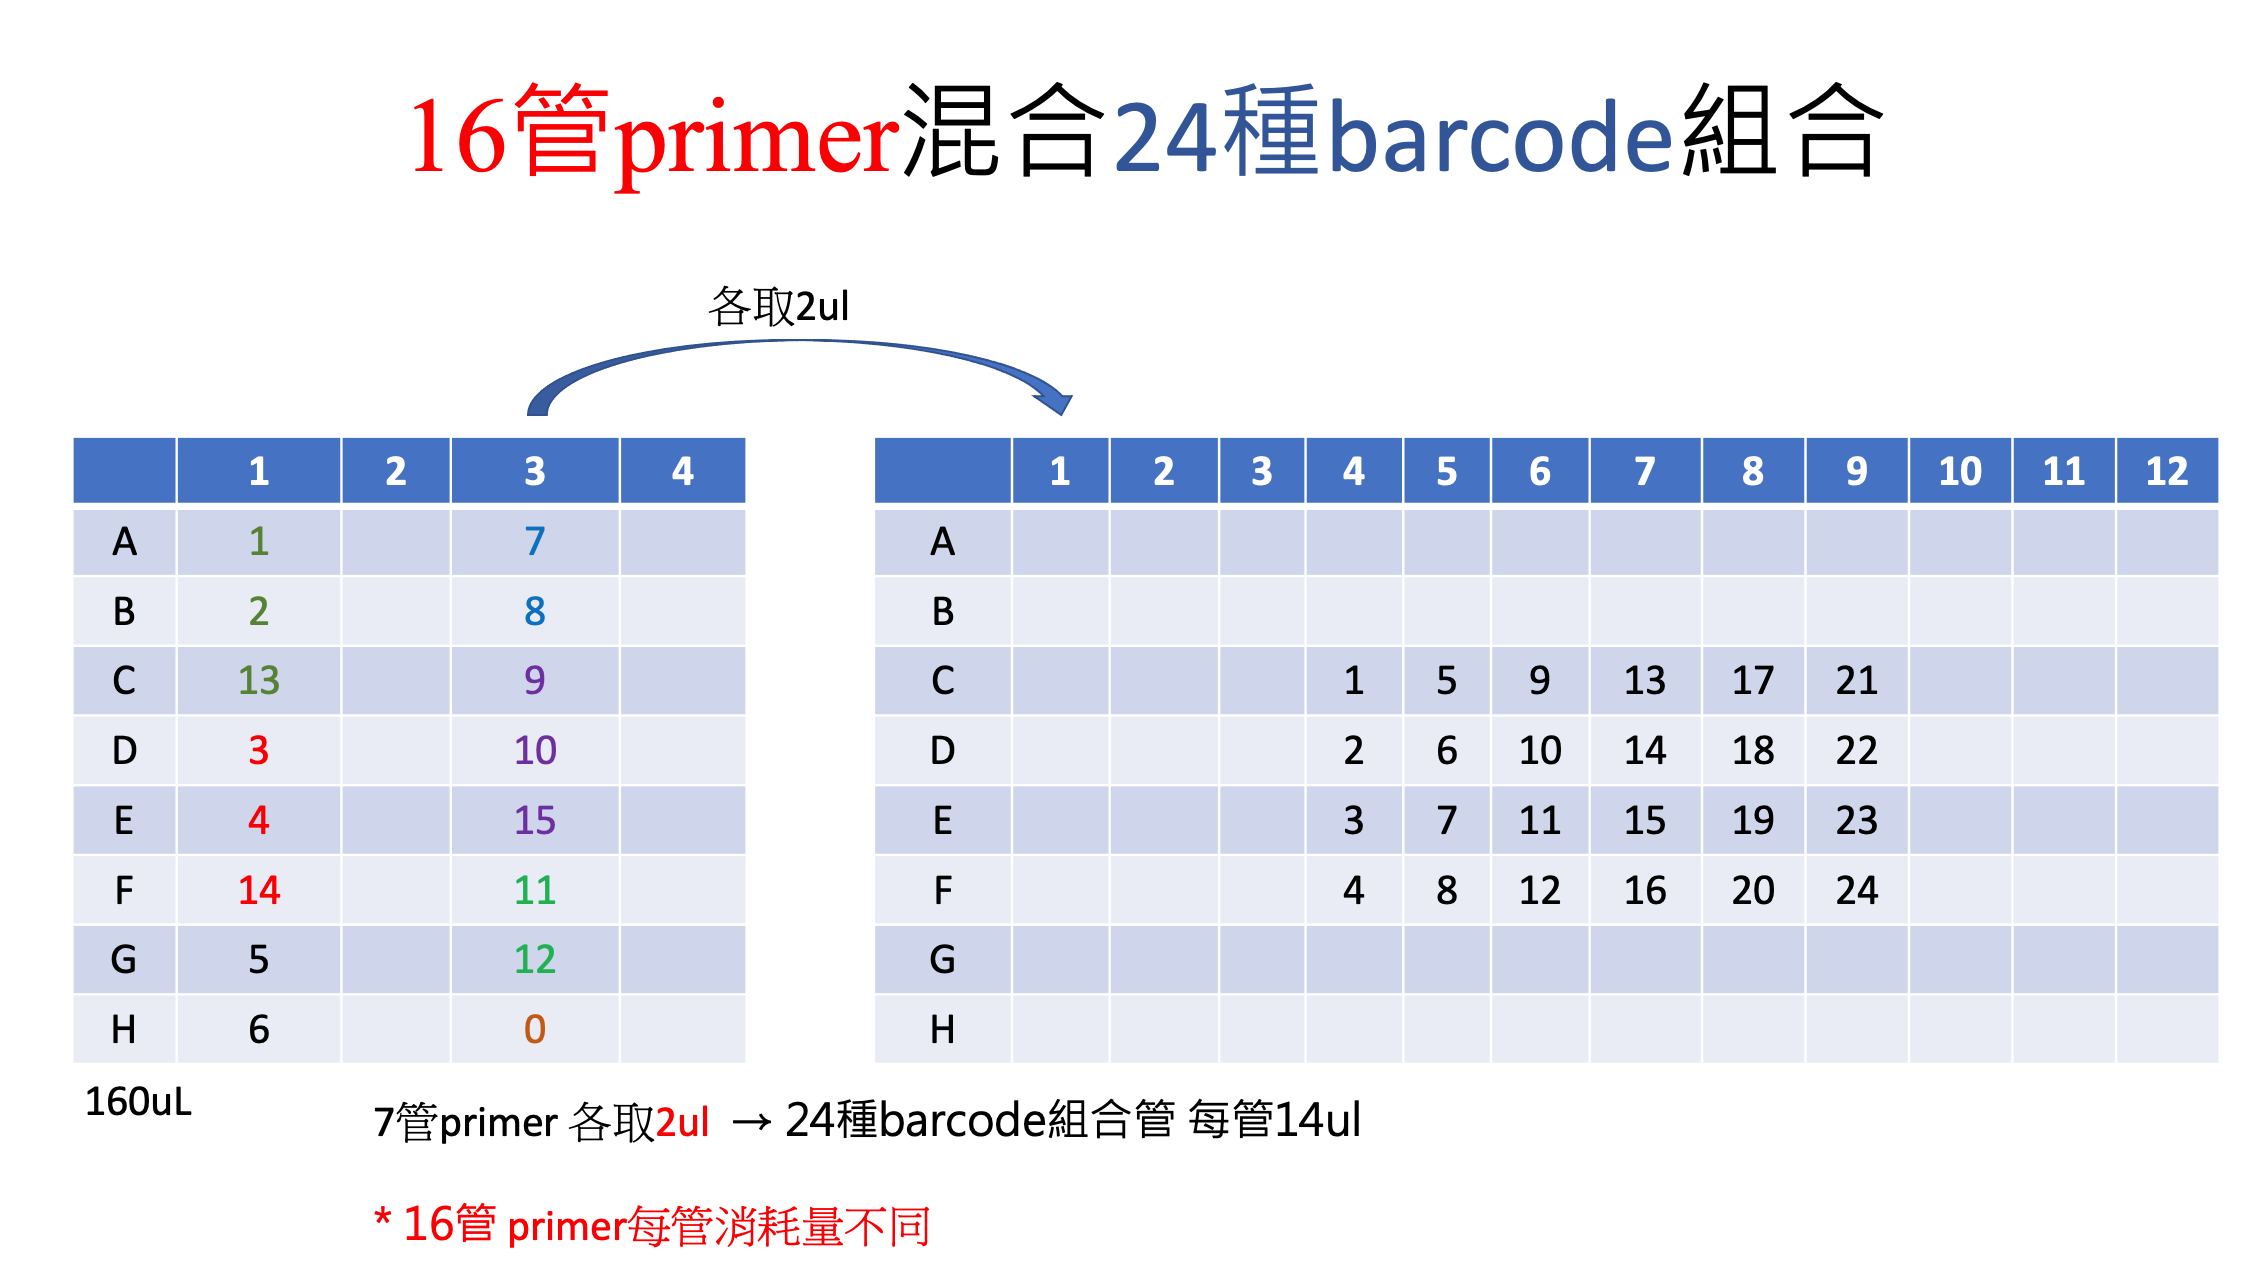


'C4'

In [8]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
#https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i ot2_ssh_key  20220611_96plate_layout.csv root@169.254.199.65:/root/script
import csv
import string

inputPlate_position = {}
with open('/root/script/20220622_16tube_position.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                inputPlate_position.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

output_24_combination_layout={}        
with open('/root/script/20220622_24_endproductLayout.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                output_24_combination_layout.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1

barcode24_combination = {}
with open('/root/script/20220621_barcode24_combination.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        combination = []
        for barcode in row:
            combination.append(barcode)
        tmp ={i:combination}
        barcode24_combination.update(tmp)
        i=i+1
        
        
DNAtobarcode = {}

with open('/root/script/20220622_DNAtoPosition.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        for item in row:
            tmp ={i:item}
            DNAtobarcode.update(tmp)
        i=i+1


# Overall Workflow Design
- step 1 : put the large volume to each 24 position(A1 -> 36.5 uL): use 300ul tips
- step 2 : put primer into the each 24 position (input 96-> 24, each 2 ul)
- step 3 : put DNA into each 24 position (input 1.5 each)


# Step 1
## move  mixture to each 24 position (each 36.5 ul)

In [118]:
####### Opentrion description##############
#
# make 24 tubes with mixture 
#
###########################################
####### Set up machine pipette parameter
left_pipette.flow_rate.aspirate = 12  # speed too quick
left_pipette.flow_rate.dispense = 13
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# get the barcode tube mixture keys
mixture_keys   = list(output_24_combination_layout.keys())
mixutre_values = list(output_24_combination_layout.values())

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
left_pipette.pick_up_tip()
for item_set in mixture_keys:
    #print("set item: ",item_set,"test")
    reagent_locate = 'A1'
    destination = output_24_combination_layout[item_set]
    print(reagent_locate)
    print(destination)
    left_pipette.aspirate(36.5, LInput_container[reagent_locate])
    left_pipette.dispense(36.5, Output_container[destination])
    left_pipette.blow_out()    
left_pipette.drop_tip()

A1
C4
A1
D4
A1
E4
A1
F4
A1
C5
A1
D5
A1
E5
A1
F5
A1
C6
A1
D6
A1
E6
A1
F6
A1
C7
A1
D7
A1
E7
A1
F7
A1
C8
A1
D8
A1
E8
A1
F8
A1
C9
A1
D9
A1
E9
A1
F9


<InstrumentContext: p300_single_v2.1 in LEFT>

# Step 2
## put primer according to barcode design into 24 position (each 2 ul)

In [124]:
####### Opentrion description ===
#  put the primer according to barcode deisng, seperate into two steps due to tips
#
#  Position ONE
###########################################
####### Set up machine pipette parameter
right_pipette.flow_rate.aspirate = 1.5  # speed too quick
right_pipette.flow_rate.dispense = 1.5
right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 



# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well

for item_set in list(range(1, 17)):
    print("set item: ",item_set,"test")
    print(barcode24_combination[item_set])
    for primer in barcode24_combination[item_set]:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{item_set}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip()
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()

set item:  1 test
['1', '3', '5', '7', '10', '12']
A1
C4
D1
C4
G1
C4
A3
C4
D3
C4
G3
C4
set item:  2 test
['1', '3', '5', '7', '15', '11']
A1
D4
D1
D4
G1
D4
A3
D4
E3
D4
F3
D4
set item:  3 test
['1', '3', '5', '7', '15', '12']
A1
E4
D1
E4
G1
E4
A3
E4
E3
E4
G3
E4
set item:  4 test
['1', '4', '5', '7', '9', '12']
A1
F4
E1
F4
G1
F4
A3
F4
C3
F4
G3
F4
set item:  5 test
['1', '4', '5', '7', '10', '12']
A1
C5
E1
C5
G1
C5
A3
C5
D3
C5
G3
C5
set item:  6 test
['1', '4', '5', '7', '15', '11']
A1
D5
E1
D5
G1
D5
A3
D5
E3
D5
F3
D5
set item:  7 test
['1', '4', '5', '7', '15', '12']
A1
E5
E1
E5
G1
E5
A3
E5
E3
E5
G3
E5
set item:  8 test
['1', '14', '5', '7', '9', '11']
A1
F5
F1
F5
G1
F5
A3
F5
C3
F5
F3
F5
set item:  9 test
['1', '14', '5', '7', '9', '12']
A1
C6
F1
C6
G1
C6
A3
C6
C3
C6
G3
C6
set item:  10 test
['1', '14', '5', '7', '10', '11']
A1
D6
F1
D6
G1
D6
A3
D6
D3
D6
F3
D6
set item:  11 test
['1', '14', '5', '7', '10', '12']
A1
E6
F1
E6
G1
E6
A3
E6
D3
E6
G3
E6
set item:  12 test
['1', '14', '5', '7',

OutOfTipsError: 

In [140]:
for item_set in list(range(16, 17)):
    print("set item: ",item_set,"test")
    print(tmp_barcode24_combination)
    for primer in tmp_barcode24_combination:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{item_set}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip()
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


set item:  16 test
['15', '12']
E3
F7
G3
F7


### Please change the tips rack here "**************************************"

In [146]:
####### Opentrion description ===
#  put the primer according to barcode deisng, seperate into two steps due to tips
#
#  Position TWO
###########################################
for item_set in list(range(17, 25)):
    print("set item: ",item_set,"test")
    print(barcode24_combination[item_set])
    for primer in barcode24_combination[item_set]:
        primer_locate = inputPlate_position[primer]
        destination = output_24_combination_layout[f"{item_set}"]
        print(primer_locate)
        print(destination)
        right_pipette.pick_up_tip()
        right_pipette.aspirate(2, Input_container[primer_locate])
        right_pipette.dispense(2, Output_container[destination])
        right_pipette.blow_out()    
        right_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.5353919287881 deck) too high for limit 418.0


set item:  17 test
['2', '4', '5', '7', '9', '12']
B1
C8
E1
C8
G1
C8
A3
C8
C3
C8
G3
C8
set item:  18 test
['2', '4', '5', '7', '10', '12']
B1
D8
E1
D8
G1
D8
A3
D8
D3
D8
G3
D8
set item:  19 test
['2', '4', '5', '7', '15', '11']
B1
E8
E1
E8
G1
E8
A3
E8
E3
E8
F3
E8
set item:  20 test
['2', '4', '5', '7', '15', '12']
B1
F8
E1
F8
G1
F8
A3
F8
E3
F8
G3
F8
set item:  21 test
['2', '14', '5', '7', '9', '11']
B1
C9
F1
C9
G1
C9
A3
C9
C3
C9
F3
C9
set item:  22 test
['2', '14', '5', '7', '9', '12']
B1
D9
F1
D9
G1
D9
A3
D9
C3
D9
G3
D9
set item:  23 test
['2', '14', '5', '7', '10', '11']
B1
E9
F1
E9
G1
E9
A3
E9
D3
E9
F3
E9
set item:  24 test
['2', '14', '5', '7', '10', '12']
B1
F9
F1
F9
G1
F9
A3
F9
D3
F9
G3
F9


# Step 3
## put DNA into the 24 mixture and mix (echo 1.5 ul)

In [ ]:
####### Opentrion description ===
#  
#  put the DNA to each position
#  
###########################################
####### Set up machine pipette parameter
#right_pipette.flow_rate.aspirate = 1.5  # speed too quick
#right_pipette.flow_rate.dispense = 1.5
#right_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 



# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well

for item_set in list(range(2, 25)):
    print("set item: ",item_set,"test")
    print(DNAtobarcode[item_set])
    DNAst=DNAtobarcode[item_set]
    DNA_locate = inputPlate_position[DNAst]
    destination = output_24_combination_layout[f"{item_set}"]
    print(DNA_locate)
    print(destination)    
    right_pipette.pick_up_tip()
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.aspirate(1.5, Input_container[DNA_locate])
    right_pipette.dispense(1.5, Output_container[destination])
    right_pipette.well_bottom_clearance.dispense = 2
    right_pipette.well_bottom_clearance.aspirate = 2
    right_pipette.flow_rate.dispense = 3
    right_pipette.aspirate(10, Output_container[destination])
    right_pipette.dispense(10, Output_container[destination])
    right_pipette.flow_rate.dispense = 1.5
    right_pipette.flow_rate.aspirate = 1.5
    right_pipette.well_bottom_clearance.dispense = 1
    right_pipette.well_bottom_clearance.aspirate = 1
    right_pipette.blow_out()    
    right_pipette.drop_tip()
    
    # 3 test: C7-> E4 weird
    # 4 test: C7-> E4 weird

set item:  2 test
ST7
B8
D4
set item:  3 test
ST59
C7
E4
set item:  4 test
ST15
D8
F4
set item:  5 test
ST1232
E7
C5
set item:  6 test
ST97
F8
D5
set item:  7 test
ST1
G7
E5
set item:  8 test
ST789
H8
F5
set item:  9 test
ST239
A7
C6
set item:  10 test
ST7
B8
D6
set item:  11 test
ST59
C7
E6
set item:  12 test
ST15
D8
F6
set item:  13 test
ST1232
E7
C7
set item:  14 test
ST97
F8
D7
set item:  15 test
ST1
G7
E7
set item:  16 test
ST789
H8
F7
set item:  17 test
ST239
A7
C8
set item:  18 test
ST7
B8
D8
set item:  19 test
ST59
C7
E8
set item:  20 test
ST15
D8
F8
set item:  21 test
ST1232
E7
C9
set item:  22 test
ST97
F8
D9
set item:  23 test
ST1
G7
E9


# Magnetic Purification Module Setup

# Thermocycler PCR reagent
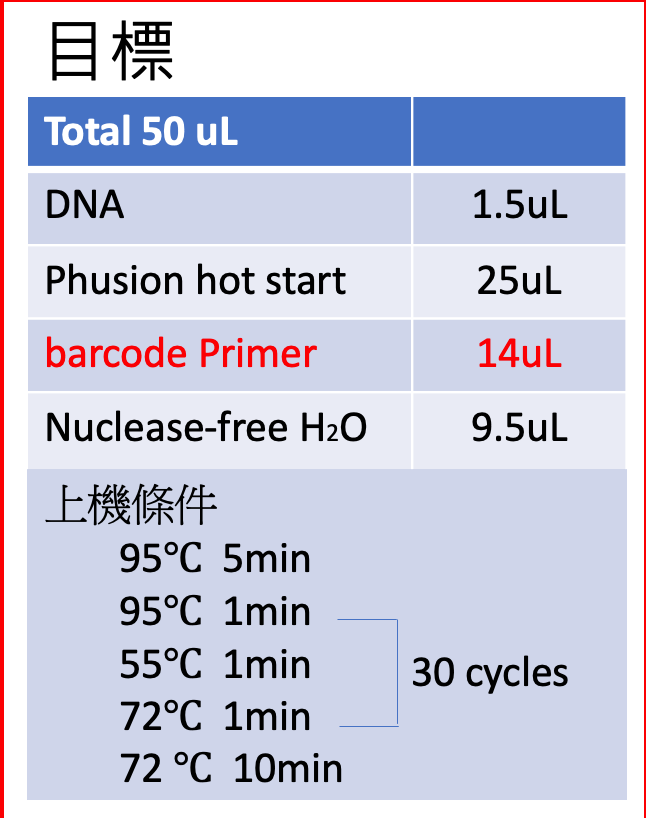

# Position Design Part: original primer position
- log: 20220610
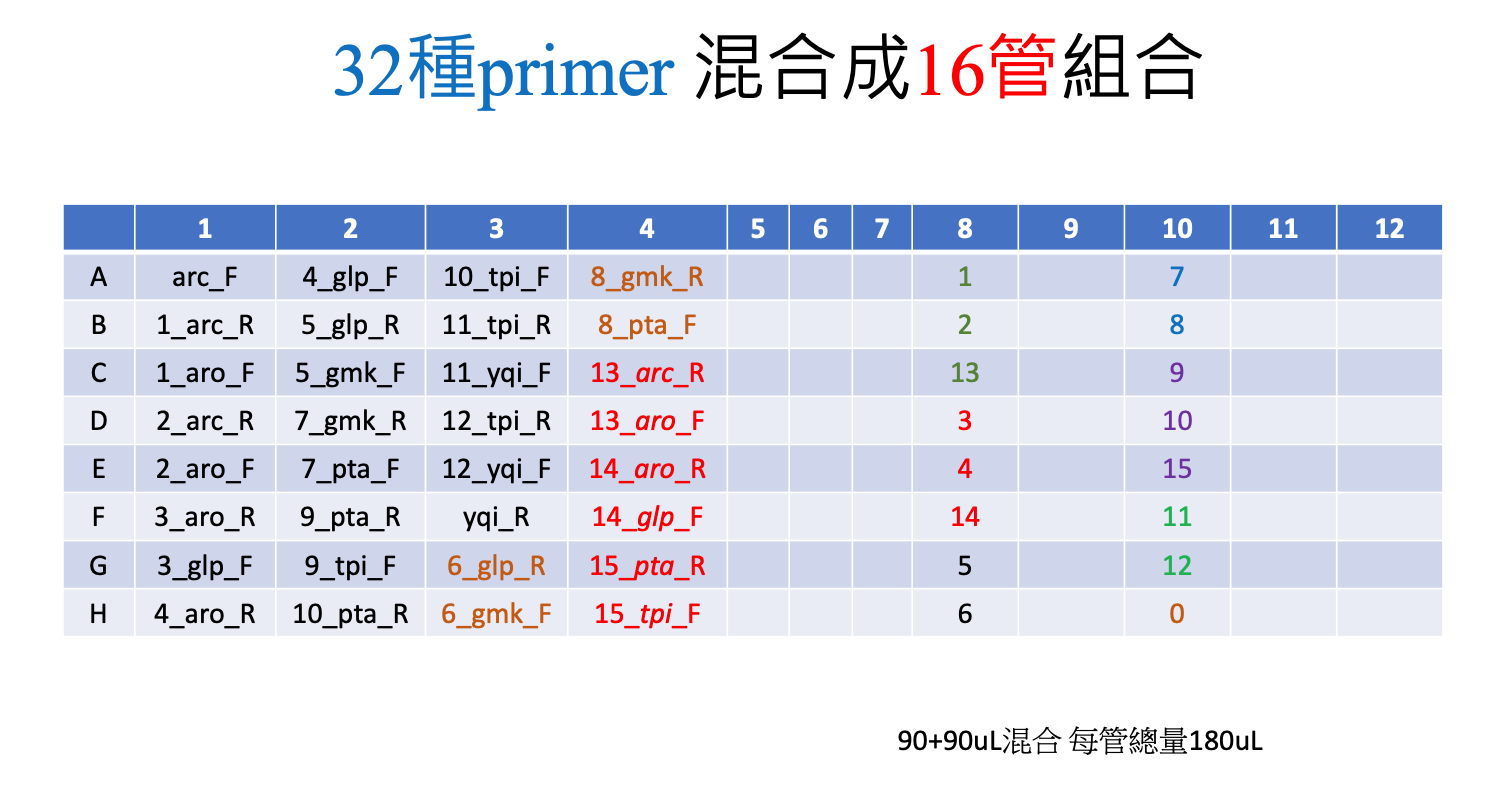

# Import plat position information from CSV

In [90]:
# primer location in 96-well: mapping primer to its physical well position
#Opentron 操作細節
#https://support.opentrons.com/s/article/Connecting-to-your-OT-2-with-SSH
https://support.opentrons.com/s/article/Setting-up-SSH-access-to-your-OT-2
# use the code to import plate mapping information into the python3
# scp -i ot2_ssh_key  20220611_96plate_layout.csv root@169.254.199.65:/root/script
import csv
import string
primer_location_list = {}
with open('/root/script/20220611_96plate_layout.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for primer in row:
            position = f"{string.ascii_uppercase[j]}{i}"
            tmp ={primer:position}
            #print(tmp)
            primer_location_list.update(tmp)
            j=j+1
        i=i+1
        
barcode_tube_mixture = {}
with open('/root/script/20220611_96plate_endproduct.csv', newline='') as f:
    reader = csv.reader(f)
    i=1
    for row in reader:
        j=0
        for endproduct in row:
            if endproduct != '':    
                position = f"{string.ascii_uppercase[j]}{i}"
                tmp ={endproduct:position}
                barcode_tube_mixture.update(tmp)
                #print(tmp)
            j=j+1
        i=i+1
        



# Opentron: mix 16 tubes of barcodes mixture

In [91]:
####### Opentrion description
# make 16 tubes with mixture primers
#
#
###########################################
####### Set up machine pipette parameter
#left_pipette.flow_rate.aspirate = 15  # speed too quick
#left_pipette.flow_rate.dispense = 15
#left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# get the barcode tube mixture keys
mixture_keys   = list(barcode_tube_mixture.keys())
mixutre_values = list(barcode_tube_mixture.values())

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
for item_set in barcode_tube_mixture:
    print("set item: ",item_set,"test")
    for primer in primer_barcode_dict[item_set]:
        primer_locate = primer_location_list[primer]
        destination = barcode_tube_mixture[item_set]
        print(primer_locate)
        print(destination)
        
        #left_pipette.pick_up_tip()
        #left_pipette.aspirate(25, primers_container[primer_locate])
        #left_pipette.dispense(25, primers_container[destination])
        #left_pipette.blow_out()    
        #left_pipette.drop_tip()

set item:  1 test
B1
A8
C1
A8
set item:  2 test
D1
B8
E1
B8
set item:  13 test
C4
C8
D4
C8
set item:  3 test
F1
D8
G1
D8
set item:  4 test
H1
E8
A2
E8
set item:  14 test
E4
F8
F4
F8
set item:  5 test
B2
G8
C2
G8
set item:  6 test
G3
H8
H3
H8
set item:  7 test
D2
A10
E2
A10
set item:  8 test
A4
B10
B4
B10
set item:  9 test
F2
C10
G2
C10
set item:  10 test
H2
D10
A3
D10
set item:  15 test
G4
E10
H4
E10
set item:  11 test
B3
F10
C3
F10
set item:  12 test
D3
G10
E3
G10
set item:  0 test
A1
H10
F3
H10


# Position Design Part: mixed tubes
- log: 20220610
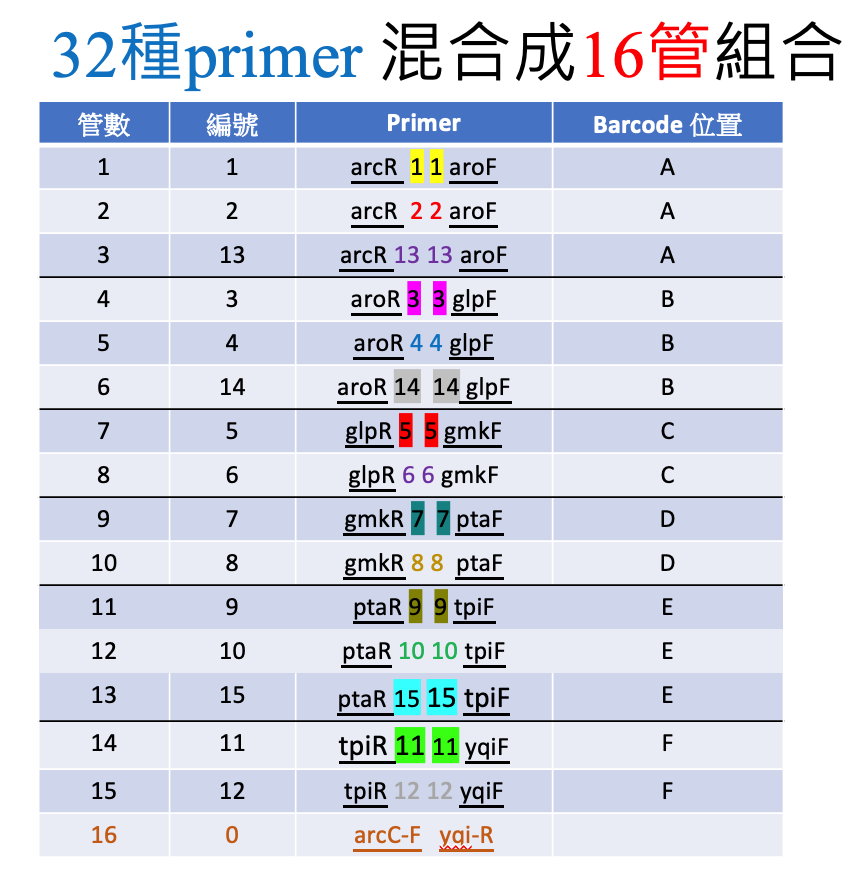

In [57]:
# Reagent volumn assessment and planning
from collections import Counter
calculation = Counter()
for primer_set in primer_list:
    for primer in primer_set:
        calculation[primer]+=1
calculation
# one for 20ul
# arc_F, yqi_R: 32 ul

NameError: name 'primer_list' is not defined

In [36]:
right_pipette.pick_up_tip()
right_pipette.drop_tip()

<InstrumentContext: p20_single_v2.1 in RIGHT>

Exception in Module registration
Traceback (most recent call last):
  File "usr/lib/python3.7/site-packages/opentrons/drivers/utils.py", line 90, in parse_device_information
  File "usr/lib/python3.7/site-packages/opentrons/drivers/utils.py", line 90, in <dictcomp>
KeyError: 'model'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 240, in handle_module_appearance
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 117, in register_modules
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/module_control.py", line 63, in build_module
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/modules/utils.py", line 37, in build
  File "usr/lib/python3.7/site-packages/opentrons/hardware_control/modules/magdeck.py", line 48, in build
  File "usr/lib/python3.7/site-packages/opentro

# Basic Practice On Moving Pipette

In [20]:
left_pipette.blow_out()    

left_pipette.drop_tip()


<InstrumentContext: p300_single_v2.1 in LEFT>

In [19]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])

left_pipette.aspirate(25, product_container['A1'])

left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹


left_pipette.dispense(25, primers_container['A1'])
left_pipette.blow_out()    

left_pipette.drop_tip()

left_pipette.well_bottom_clearance.dispense = 1

TypeError: blow_out() got an unexpected keyword argument 'v_offset'

# Combination of primers set

In [18]:
# primer location in 96-well: mapping primer to its physical well position

primer_location_list = dict({'arc_F':'A1', 
                             '1_arc_R':'B1', 
                             '1_aro_F':'C1',
                             '2_arc_R':'D1',
                             '2_aro_F':'E1',
                             '3_aro_R':'F1',
                             '3_glp_F':'G1',
                             '4_aro_R':'H1',
                             '4_glp_F':'A2',
                             '5_glp_R':'B2',
                             '5_gmk_F':'C2',
                             '7_gmk_R':'D2',
                             '7_pta_F':'E2',
                             '9_pta_R':'F2',
                             '9_tpi_F':'G2',
                             '10_pta_R':'H2',
                             '10_tpi_F':'A3',
                             '11_tpi_R':'B3',
                             '11_yqi_F':'C3',
                             '12_tpi_R':'D3',
                             '12_yqi_F':'E3',
                             'yqi_R':'F3'})

put_50_wells_1 = ["A1","D1","E1","F1", "G1", "B2"] # 300
put_50_wells_2 = ["E2","H2","A3","B3", "C3", "F3"] # 300
put_25_wells = ["B1","C1","H1","A2","C2","D2","F2","G2","D3","E3"] #250

left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹

# section 1 =============================
left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(300, product_container['A1'])


## draw multiple wells at one time
for well in put_50_wells_1:
    left_pipette.dispense(50, primers_container[well])

left_pipette.blow_out(v_offset=3)    
left_pipette.drop_tip()

# section 2 =============================
left_pipette.pick_up_tip(tips_300['B1'])
left_pipette.aspirate(300, product_container['B1'])


## draw multiple wells at one time
for well in put_50_wells_2:
    left_pipette.dispense(50, primers_container[well])
    
left_pipette.blow_out()    
left_pipette.drop_tip()

# section 3 =============================
left_pipette.pick_up_tip(tips_300['C1'])
left_pipette.aspirate(250, product_container['C1'])

## draw multiple wells at one time
for well in put_25_wells:
    left_pipette.dispense(25, primers_container[well])

left_pipette.blow_out()    
left_pipette.drop_tip()


left_pipette.well_bottom_clearance.dispense = 1

In [50]:
primer_location_list = dict({'arc_F':'A1', 
                             '1_arc_R':'B1', 
                             '2_arc_R':'C1',
                             '1_aro_F':'D1',
                             '2_aro_F':'E1',
                             '3_aro_R':'F1',
                             '4_aro_R':'G1',
                             '3_glp_F':'H1',
                             '4_glp_F':'A2',
                             '5_glp_R':'B2',
                             '5_gmk_F':'C2',
                             '7_gmk_R':'D2',
                             '7_pta_F':'E2',
                             '9_pta_R':'F2',
                             '10_pta_R':'G2',
                             '9_tpi_F':'H2',
                             '10_tpi_F':'A3',
                             '11_tpi_R':'B3',
                             '12_tpi_R':'C3',
                             '11_yqi_F':'D3',
                             '12_yqi_F':'E3',
                             'yqi_R':'F3'})

primer_product_list = dict({'1A':'A10',
                            '1B':'B10',
                            '2A':'C10',
                            '2B':'D10',
                            '2C':'E10',
                            '2D':'F10',
                            '3A':'G10',
                            '3B':'H10',
                            '4A':'A11',
                            '5A':'B11',
                            '5B':'C11',
                            '6A':'D11',
                            '6B':'E11',
                            '6C':'F11',
                            '6D':'G11',
                            '7A':'H11',
                            '7B':'A12'})

primer_set_list = dict({'1A':['arc_F', '1_arc_R'],
                        '1B':['arc_F', '2_arc_R'],
                            '2A':['1_aro_F','3_aro_R'],
                            '2B':['2_aro_F','3_aro_R'],
                            '2C':['1_aro_F','4_aro_R'],
                            '2D':['2_aro_F','4_aro_R'],
                            '3A':['3_glp_F','5_glp_R'],
                            '3B':['4_glp_F','5_glp_R'],
                            '4A':['5_gmk_F','7_gmk_R'],
                            '5A':['7_pta_F','9_pta_R'],
                            '5B':['7_pta_F','10_pta_R'],
                            '6A':['9_tpi_F','11_tpi_R'],
                            '6B':['10_tpi_F','11_tpi_R'],
                            '6C':['9_tpi_F','12_tpi_R'],
                            '6D':['10_tpi_F','12_tpi_R'],
                            '7A':['11_yqi_F','yqi_R'],
                            '7B':['12_yqi_F','yqi_R']})



In [52]:
left_pipette.flow_rate.aspirate = 15  # speed too quick
left_pipette.flow_rate.dispense = 15
left_pipette.well_bottom_clearance.dispense = 1 # 這高度就算可以惹 

# Dedault Aspirate 1mm above the bottom of the well
# Aspirate 1mm above the bottom of the well
for item_set in primer_set_list:
    print("set item: ",item_set,"test")
    for primer in primer_set_list[item_set]:
        primer_locate = primer_location_list[primer]
        destination = primer_product_list[item_set]
        print(primer_locate)
        print(destination)
        
        left_pipette.pick_up_tip()
        left_pipette.aspirate(25, primers_container[primer_locate])
        left_pipette.dispense(25, primers_container[destination])
        #left_pipette.blow_out()    
        left_pipette.drop_tip()

set item:  1A test
A1
A10
B1
A10
set item:  1B test
A1
B10
C1
B10
set item:  2A test
D1
C10
F1
C10
set item:  2B test
E1
D10
F1
D10
set item:  2C test
D1
E10
G1
E10
set item:  2D test
E1
F10
G1
F10
set item:  3A test
H1
G10
B2
G10
set item:  3B test
A2
H10
B2
H10
set item:  4A test
C2
A11
D2
A11
set item:  5A test
E2
B11
F2
B11
set item:  5B test
E2
C11
G2
C11
set item:  6A test
H2
D11
B3
D11
set item:  6B test
A3
E11
B3
E11
set item:  6C test
H2
F11
C3
F11
set item:  6D test
A3
G11
C3
G11
set item:  7A test
D3
H11
F3
H11
set item:  7B test
E3
A12
F3
A12


In [ ]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹

# section 1 =============================

## draw multiple wells at one time
for primer_set in put_50_wells_1:
    left_pipette.pick_up_tip()
    left_pipette.aspirate(300, product_container['A1'])
    left_pipette.dispense(50, primers_container[well])

left_pipette.blow_out(v_offset=3)    
left_pipette.drop_tip()


# single move function for each primer

In [ ]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(25, dye_container['B1'])
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹
left_pipette.dispense(35, A_plate['A2'])
left_pipette.dispense(35, A_plate['B2'])
left_pipette.dispense(35, A_plate['C2'])
left_pipette.dispense(35, A_plate['D2'])
left_pipette.dispense(35, A_plate['E2'])
left_pipette.dispense(35, A_plate['F2'])
left_pipette.dispense(35, A_plate['G2'])
left_pipette.dispense(35, A_plate['H2'])
left_pipette.drop_tip()
left_pipette.well_bottom_clearance.dispense = 1

# Test p300 and multiple dispense

In [15]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

left_pipette.pick_up_tip(tips_300['A1'])
left_pipette.aspirate(30, product_container['A1'])
left_pipette.well_bottom_clearance.dispense = 1.5 # 這高度就算可以惹
left_pipette.dispense(35, A_plate['A2'])
left_pipette.drop_tip()
left_pipette.well_bottom_clearance.dispense = 1

# Test p20 and multiple dispense

In [18]:
right_pipette.flow_rate.aspirate  = 2
right_pipette.flow_rate.dispense  = 2
right_pipette.pick_up_tip(tips_10['C1'])
right_pipette.well_bottom_clearance.aspirate = 1.1 # 這高度就算可以惹
right_pipette.well_bottom_clearance.dispense = 1.2 # 這高度就算可以惹
right_pipette.aspirate(10, A_plate['C2'])
right_pipette.dispense(1, B_plate['B4'])
right_pipette.dispense(1, B_plate['C4'])
right_pipette.dispense(1, B_plate['D4'])
right_pipette.dispense(1, B_plate['E4'])
right_pipette.dispense(1, B_plate['F4'])
right_pipette.dispense(1, B_plate['G4'])
right_pipette.dispense(1, B_plate['H4'])
right_pipette.drop_tip()
right_pipette.well_bottom_clearance.dispense = 1

Pause with message: /dev/ot_module_thermocycler0: No response to 'M141 
'


# Protocol

##  pipete setting
for p300
aspirate at the default flowraet of 150 uL/s
dispense at the default flowrate of 300 ul/s
fof p20
aspiration, dispense default flowrate: 3.78 ul/s, range 0.1 - 20

In [7]:
left_pipette.flow_rate.aspirate = 30
left_pipette.flow_rate.dispense = 30

In [34]:
left_pipette.pick_up_tip(tips_300['A1']) # pick tips
left_pipette.aspirate(100, dye_container['D1']) # pick Red
left_pipette.dispense(100, B_plate['A1']) # draw 
left_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.6703677749266 deck) too high for limit 418.0


<InstrumentContext: p300_single_v2.1 in LEFT>

In [7]:
# draw function
def draw_at(tip_location, draw_position, color_pos):
    left_pipette.pick_up_tip(tips[tip_location]) # pick tips
    left_pipette.aspirate(50, dye_container[color_pos]) # pick Red
    left_pipette.dispense(50, test_plate[draw_position]) # draw 
    left_pipette.blow_out()
    left_pipette.drop_tip()

In [8]:
draw_at(tip_location="A3", draw_position="A3", color_pos="A1")

## Practice 01:Draw a "line" program

In [17]:
blue_wells = ["G2","F3","E4","D5"]

## pick up tips 
left_pipette.pick_up_tip(tips["A2"])

## pick up color reagent
left_pipette.aspirate(200, dye_container["A1"])

## draw multiple wells at one time

for well in blue_wells:
    left_pipette.dispense(50, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

## Practice 02: Draw complex figure

In [18]:
green_wells = ["F5","G6"]

## pick up tips 
left_pipette.pick_up_tip(tips["A3"])

## pick up color reagent
left_pipette.aspirate(100, dye_container["D1"])

## draw multiple wells at one time

for well in green_wells:
    left_pipette.dispense(50, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()


red_wells = ["H5","F7","E8","D9","C10","D11", "E12"]

## pick up tips 
left_pipette.pick_up_tip(tips["A4"])

## pick up color reagent
left_pipette.aspirate(280, dye_container["C1"])

## draw multiple wells at one time

for well in red_wells:
    left_pipette.dispense(40, test_plate[well])

# finish and drop tips    
left_pipette.blow_out()
left_pipette.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

## Practice 03: use two loop to draw

In [11]:
blue_wells = ["A4","B3","B4","B5","D4"]
yellow_wells = ["D1","D2","C2","E2"]
red_wells = ["F3","F4","F5","G4","D4"]
green_wells = ["D6","D7","C6","E6"]

all_color_list = [blue_wells, yellow_wells, red_wells, green_wells]

tips_position = ["B1", "B2", "B3", "B4"]
color_position = ["A1", "B1", "C1", "D1"]
each_round_volumn = [250, 240, 250, 200]
dispense_volum = [50, 60, 50, 50]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

## Practice 2: draw a "A"
simplifier

In [33]:
blue_wells = ["A5"]
red_wells = ["B4","C3","D2","E2","F2","G2"]
yellow_wells = ["B6","C7","D8","E8","F8","G8"]
green_wells = ["E3","E4","E5","E6","E7"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["A1", "A2", "A3", "A4"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [50, 300, 300, 250]



for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(50, test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

## Practice 3: draw a "Love"

In [29]:
blue_wells = ["D2", "E2", "F2", "F3", "F4"]
red_wells = ["D5","E5","F5","D6","D7","E7", "F7", "F6"]
yellow_wells = ["D8","E8","F9","E10","D10"]
green_wells = ["C11","C12","D11","E11","E12", "F11", "G11", "G12"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["B1", "B2", "B3", "B4"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [250, 280, 250, 280]
dispense_volum = [50, 35, 50, 35]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()

Out of bounds move: X=(418.00000000000006 motor controller, 416.6703677749266 deck) too high for limit 418.0


# Practice 4: draw a "OK"

In [24]:
blue_wells = ["B2", "C2", "D2", "F2", "G2"]
red_wells = ["B3","B4","C4","D4","E4","F4", "G4", "G3"]
yellow_wells = ["B6","C6","D6","E6","F6", "G6"]
green_wells = ["B9", "C8", "D7", "E7", "F8", "G9"]
all_color_list = [blue_wells, red_wells, yellow_wells, green_wells]
tips_position = ["A2", "A3", "A4", "A5"]
color_position = ["A1", "C1", "B1", "D1"]
each_round_volumn = [250, 280, 240, 240]
dispense_volum = [50, 35, 40, 40]


for i in [0,1,2,3]:
    ## pick up tips 
    left_pipette.pick_up_tip(tips[tips_position[i]])

    ## pick up color reagent
    left_pipette.aspirate(each_round_volumn[i], dye_container[color_position[i]])

    ## draw multiple wells at one time

    for well in all_color_list[i]:
        left_pipette.dispense(dispense_volum[i], test_plate[well])

    # finish and drop tips    
    left_pipette.blow_out()
    left_pipette.drop_tip()